In [1]:
%matplotlib widget
%matplotlib inline
import torch
import torch.nn as nn
import pickle
import time
import copy
import os
from queue import LifoQueue
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
import numpy as np
import sys
from sklearn.tree import DecisionTreeClassifier
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from tqdm.notebook import tqdm
from sklearn.metrics import pairwise_distances
import network.cpc
from network.cpc import CDCK2
from utils.MatplotlibUtils import reduce_dims_and_plot
from utils.ClassificationUtiols import onehot_coding
from soft_decision_tree.sdt_model import SDT
from sklearn import tree as tt

# IPython.OutputArea.auto_scroll_threshold = 9999;

# Load the model and the dataset

In [2]:
model_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_128/models/epoch_40.pt'
dataset_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_128/data/test_data_protocol_4.file'

print(f"Load the model from: {model_path}")
model = torch.load(model_path, map_location='cpu')

with open(dataset_path, 'rb') as fp:
    dataset = pickle.load(fp)

all_sensors = dataset.dataset.all_signals    
print(f"sensor names: ({len(all_sensors)} total)")

for s in all_sensors:
    print(f"- {s}")
    
print(f"Multihorizon size of the model: {model.timestep}")
print(f"Test split ratio: {len(dataset) / len(dataset.dataset)}")
print(f"Total number of windows in the dataset (without splitting): {len(dataset.dataset)}")

Load the model from: /home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_128/models/epoch_40.pt
sensor names: (18 total)
- speed
- steering_angle
- wheel_speed_0
- wheel_speed_1
- wheel_speed_2
- wheel_speed_3
- accelerometer_0
- accelerometer_1
- accelerometer_2
- gyro_0
- gyro_1
- gyro_2
- gyro_bias_0
- gyro_bias_1
- gyro_bias_2
- gyro_uncalibrated_0
- gyro_uncalibrated_1
- gyro_uncalibrated_2
Multihorizon size of the model: 30
Test split ratio: 0.2
Total number of windows in the dataset (without splitting): 101465


In [3]:
batch_size = 500
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Extract representations

In [4]:
projections = torch.tensor([])
samples = torch.tensor([])
device = 'cuda'
model = model.to(device).eval()

with torch.no_grad():
    bar = tqdm(total=len(loader.dataset))
    for batch in loader:
        hidden = CDCK2.init_hidden(len(batch))
        batch = batch.to(device)
        hidden = hidden.to(device)

        y = model.predict(batch, hidden).detach().cpu()
        projections = torch.cat([projections, y.detach().cpu()])
        samples = torch.cat([samples, batch.detach().cpu()])
        bar.update(y.shape[0])

  0%|          | 0/20293 [00:00<?, ?it/s]

# Fit GMM and calculate indices

In [5]:
scores = []
best_score = float('inf')
clusters = None
range_ = list(range(5, 20))
for k in tqdm(range_):
    y = GaussianMixture(n_components=k).fit_predict(projections)
    cur_score = davies_bouldin_score(projections, y)
    scores.append(cur_score)
    
    if cur_score < best_score:
        best_score = cur_score
        clusters = y

  0%|          | 0/15 [00:00<?, ?it/s]

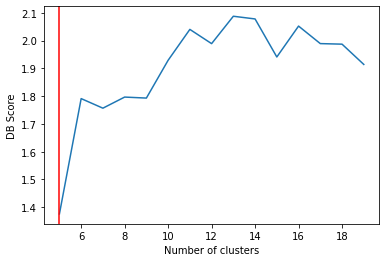

{0, 1, 2, 3, 4}


In [6]:
plt.figure()
plt.xlabel('Number of clusters')
plt.ylabel('DB Score')
plt.plot(range_, scores)
best_k = range_[np.argmin(scores)]
plt.axvline(best_k, color='r')
plt.show()

labels = set(clusters)
print(labels)

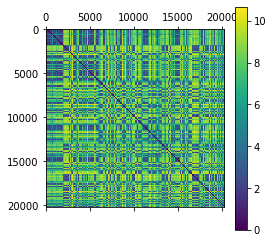

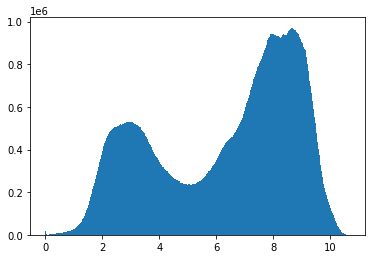

In [7]:
distances = pairwise_distances(projections)
# distances = np.triu(distances)
distances_f = distances.flatten()

plt.matshow(distances)
plt.colorbar()
plt.figure()
plt.hist(distances_f[distances_f > 0], bins=1000)
plt.show()

# Visualize with T-SNE

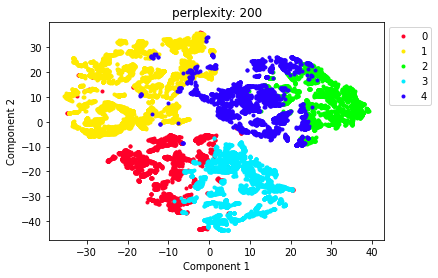

In [8]:
perplexity = 200

p = reduce_dims_and_plot(projections,
                         y=clusters,
                         title=f'perplexity: {perplexity}',
                         file_name=None,
                         perplexity=perplexity,
                         library='Multicore-TSNE',
                         perform_PCA=False,
                         projected=None,
                         figure_type='2d',
                         show_figure=True,
                         close_figure=False,
                         text=None)    

# Train a Soft-Decision-Tree given the self-labels

## Prepare the dataset

In [9]:
# unnormalized_samples = samples.clone()

# for col, sensor in enumerate(tqdm(dataset.dataset.all_signals)):
#     denormalizer = dataset.dataset.get_denormalization_for_sensor(sensor)
#     unnormalized_samples[:, col, :] = denormalizer(unnormalized_samples[:, col, :])

sampled = samples[..., range(0, samples.shape[-1], 200)]

samples_f = sampled.flatten(1)
tree_dataset = list(zip(samples_f, clusters))
batch_size = 2000
tree_loader = torch.utils.data.DataLoader(tree_dataset, batch_size=batch_size, shuffle=True)

# Define how we prune the weights of a node

In [10]:
def prune_node(node_weights, factor=1):
    w = node_weights.cpu().detach().numpy()
    mean_ = np.mean(w)
    std_ = np.std(w)
    node_weights[((mean_ - std_ * factor) < node_weights) & (node_weights < (mean_ + std_ * factor))] = 0
    return node_weights

def prune_node_keep(node_weights, keep=4):
    w = node_weights.cpu().detach().numpy()
    throw_idx = np.argsort(abs(w))[:-keep]
    node_weights[throw_idx] = 0
    return node_weights

def prune_tree(tree_, factor):
    new_weights = tree_.inner_nodes.weight.clone()
    for i in range(new_weights.shape[0]):
        res = prune_node_keep(new_weights[i, :], factor)
        new_weights[i, :] = res

    with torch.no_grad():
        tree_.inner_nodes.weight.copy_(new_weights)
        
def sparseness(x):
    s = []
    for i in range(x.shape[0]):
        x_ = x[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        s.append(sp)
    return np.mean(s)

def compute_regularization_by_level(tree):
    total_reg = 0
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_level = np.floor(np.log2(i+1))
        node_reg = torch.norm(tree.inner_nodes.weight[i].view(-1), 2)
        total_reg += 2**(-cur_level) * node_reg
    return total_reg

def show_sparseness(tree):
    avg_sp = sparseness(tree.inner_nodes.weight)
    print(f"Average sparseness: {avg_sp}")
    layer = 0
    sps = []
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_layer = int(np.floor(np.log2(i+1)))
        if cur_layer != layer:
            print(f"layer {layer}: {np.mean(sps)}")
            sps = []
            layer = cur_layer

        x_ = tree.inner_nodes.weight[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        sps.append(sp)
        
    return avg_sp

## Training configurations

In [11]:
def do_epoch(model, loader, device, log_interval, losses, accs, epoch, iteration):
    model = model.train()
    for batch_idx, (data, target) in enumerate(loader):
        iteration += 1
        data, target = data.to(device), target.to(device)

        output, penalty = tree.forward(data)

        # Loss
        loss_tree = criterion(output, target.view(-1))

        # Penalty
        loss_tree += penalty

        # Sparse regularization
#         fc_params = torch.cat([x.view(-1) for x in tree.inner_nodes.parameters()])
#         regularization = sparsity_lamda * torch.norm(fc_params, 2)
        regularization = sparsity_lamda * compute_regularization_by_level(tree)
        loss = loss_tree

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        pred = output.data.max(1)[1]
        correct = pred.eq(target.view(-1).data).sum()
        accs.append(correct.item() / data.size()[0])

        # Print training status
        if batch_idx % log_interval == 0:
            print(f"Epoch: {epoch:02d} | Batch: {batch_idx:03d} / {len(loader):03d} | Total loss: {loss.item():.3f} | Reg loss: {regularization.item():.3f} | Tree loss: {loss_tree.item():.3f} | Accuracy: {correct.item() / data.size()[0]:03f} | {round((time.time() - start_time) / iteration, 3)} sec/iter")
            
    return iteration


In [12]:
lr = 5e-3
weight_decay = 5e-4
sparsity_lamda = 2e-3
epochs = 500
output_dim = len(set(clusters))
log_interval = 1
tree_depth = 8

In [13]:
tree = SDT(input_dim=samples_f.shape[1], output_dim=len(labels), depth=tree_depth, lamda=1e-3, use_cuda=True)
optimizer = torch.optim.Adam(tree.parameters(),
                                 lr=lr,
                                 weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
tree = tree.to(device)
clf = DecisionTreeClassifier(max_depth=tree_depth).fit(samples_f, clusters)
print(f"DT accuracy: {clf.score(samples_f, clusters)}")
tree.initialize_from_decision_tree(clf)

DT accuracy: 0.9326368698566008


In [14]:
losses = []
accs = []
sparsity = []

In [15]:
start_time = time.time()
iteration = 0
for epoch in range(epochs):
    # Training
    avg_sp = show_sparseness(tree)
    sparsity.append(avg_sp)
    iteration = do_epoch(tree, tree_loader, device, log_interval, losses, accs, epoch, iteration)
    
    if epoch % 1 == 0:
        prune_tree(tree, factor=5)
        

Average sparseness: 0.5817354566135847
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.988950276243094
layer 3: 0.988950276243094
layer 4: 0.988950276243094
layer 5: 0.8344267955801106
layer 6: 0.6335462707182321
Epoch: 00 | Batch: 000 / 011 | Total loss: 1.612 | Reg loss: 0.016 | Tree loss: 1.612 | Accuracy: 0.287000 | 1.423 sec/iter
Epoch: 00 | Batch: 001 / 011 | Total loss: 1.594 | Reg loss: 0.016 | Tree loss: 1.594 | Accuracy: 0.250500 | 0.818 sec/iter
Epoch: 00 | Batch: 002 / 011 | Total loss: 1.578 | Reg loss: 0.016 | Tree loss: 1.578 | Accuracy: 0.319500 | 0.619 sec/iter
Epoch: 00 | Batch: 003 / 011 | Total loss: 1.560 | Reg loss: 0.016 | Tree loss: 1.560 | Accuracy: 0.423500 | 0.52 sec/iter
Epoch: 00 | Batch: 004 / 011 | Total loss: 1.541 | Reg loss: 0.016 | Tree loss: 1.541 | Accuracy: 0.435500 | 0.459 sec/iter
Epoch: 00 | Batch: 005 / 011 | Total loss: 1.535 | Reg loss: 0.016 | Tree loss: 1.535 | Accuracy: 0.404500 | 0.418 sec/iter
Epoch: 00 | Batch: 006 / 01

Epoch: 05 | Batch: 000 / 011 | Total loss: 1.520 | Reg loss: 0.015 | Tree loss: 1.520 | Accuracy: 0.406500 | 0.447 sec/iter
Epoch: 05 | Batch: 001 / 011 | Total loss: 1.511 | Reg loss: 0.016 | Tree loss: 1.511 | Accuracy: 0.415000 | 0.443 sec/iter
Epoch: 05 | Batch: 002 / 011 | Total loss: 1.486 | Reg loss: 0.016 | Tree loss: 1.486 | Accuracy: 0.447000 | 0.439 sec/iter
Epoch: 05 | Batch: 003 / 011 | Total loss: 1.475 | Reg loss: 0.016 | Tree loss: 1.475 | Accuracy: 0.452500 | 0.435 sec/iter
Epoch: 05 | Batch: 004 / 011 | Total loss: 1.461 | Reg loss: 0.016 | Tree loss: 1.461 | Accuracy: 0.453500 | 0.431 sec/iter
Epoch: 05 | Batch: 005 / 011 | Total loss: 1.456 | Reg loss: 0.016 | Tree loss: 1.456 | Accuracy: 0.419500 | 0.428 sec/iter
Epoch: 05 | Batch: 006 / 011 | Total loss: 1.442 | Reg loss: 0.016 | Tree loss: 1.442 | Accuracy: 0.418500 | 0.425 sec/iter
Epoch: 05 | Batch: 007 / 011 | Total loss: 1.433 | Reg loss: 0.017 | Tree loss: 1.433 | Accuracy: 0.423000 | 0.421 sec/iter
Epoch: 0

Epoch: 10 | Batch: 002 / 011 | Total loss: 1.380 | Reg loss: 0.018 | Tree loss: 1.380 | Accuracy: 0.487000 | 0.398 sec/iter
Epoch: 10 | Batch: 003 / 011 | Total loss: 1.356 | Reg loss: 0.018 | Tree loss: 1.356 | Accuracy: 0.506000 | 0.396 sec/iter
Epoch: 10 | Batch: 004 / 011 | Total loss: 1.344 | Reg loss: 0.018 | Tree loss: 1.344 | Accuracy: 0.507000 | 0.394 sec/iter
Epoch: 10 | Batch: 005 / 011 | Total loss: 1.315 | Reg loss: 0.019 | Tree loss: 1.315 | Accuracy: 0.556000 | 0.393 sec/iter
Epoch: 10 | Batch: 006 / 011 | Total loss: 1.299 | Reg loss: 0.019 | Tree loss: 1.299 | Accuracy: 0.547000 | 0.391 sec/iter
Epoch: 10 | Batch: 007 / 011 | Total loss: 1.291 | Reg loss: 0.019 | Tree loss: 1.291 | Accuracy: 0.540500 | 0.389 sec/iter
Epoch: 10 | Batch: 008 / 011 | Total loss: 1.278 | Reg loss: 0.019 | Tree loss: 1.278 | Accuracy: 0.547000 | 0.388 sec/iter
Epoch: 10 | Batch: 009 / 011 | Total loss: 1.270 | Reg loss: 0.020 | Tree loss: 1.270 | Accuracy: 0.534000 | 0.387 sec/iter
Epoch: 1

Epoch: 15 | Batch: 004 / 011 | Total loss: 1.231 | Reg loss: 0.020 | Tree loss: 1.231 | Accuracy: 0.554500 | 0.403 sec/iter
Epoch: 15 | Batch: 005 / 011 | Total loss: 1.204 | Reg loss: 0.020 | Tree loss: 1.204 | Accuracy: 0.546000 | 0.402 sec/iter
Epoch: 15 | Batch: 006 / 011 | Total loss: 1.195 | Reg loss: 0.020 | Tree loss: 1.195 | Accuracy: 0.567500 | 0.401 sec/iter
Epoch: 15 | Batch: 007 / 011 | Total loss: 1.179 | Reg loss: 0.021 | Tree loss: 1.179 | Accuracy: 0.580000 | 0.4 sec/iter
Epoch: 15 | Batch: 008 / 011 | Total loss: 1.187 | Reg loss: 0.021 | Tree loss: 1.187 | Accuracy: 0.562500 | 0.399 sec/iter
Epoch: 15 | Batch: 009 / 011 | Total loss: 1.167 | Reg loss: 0.021 | Tree loss: 1.167 | Accuracy: 0.562500 | 0.398 sec/iter
Epoch: 15 | Batch: 010 / 011 | Total loss: 1.154 | Reg loss: 0.021 | Tree loss: 1.154 | Accuracy: 0.587031 | 0.397 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.

Epoch: 20 | Batch: 006 / 011 | Total loss: 1.129 | Reg loss: 0.021 | Tree loss: 1.129 | Accuracy: 0.502500 | 0.406 sec/iter
Epoch: 20 | Batch: 007 / 011 | Total loss: 1.109 | Reg loss: 0.021 | Tree loss: 1.109 | Accuracy: 0.528000 | 0.405 sec/iter
Epoch: 20 | Batch: 008 / 011 | Total loss: 1.106 | Reg loss: 0.021 | Tree loss: 1.106 | Accuracy: 0.526000 | 0.404 sec/iter
Epoch: 20 | Batch: 009 / 011 | Total loss: 1.075 | Reg loss: 0.022 | Tree loss: 1.075 | Accuracy: 0.546500 | 0.403 sec/iter
Epoch: 20 | Batch: 010 / 011 | Total loss: 1.036 | Reg loss: 0.022 | Tree loss: 1.036 | Accuracy: 0.587031 | 0.402 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 21 | Batch: 000 / 011 | Total loss: 1.239 | Reg loss: 0.021 | Tree loss: 1.239 | Accuracy: 0.505500 | 0.411 sec/iter
Epoch: 21 | Batch: 00

Epoch: 25 | Batch: 008 / 011 | Total loss: 1.011 | Reg loss: 0.022 | Tree loss: 1.011 | Accuracy: 0.562500 | 0.408 sec/iter
Epoch: 25 | Batch: 009 / 011 | Total loss: 0.991 | Reg loss: 0.022 | Tree loss: 0.991 | Accuracy: 0.582000 | 0.407 sec/iter
Epoch: 25 | Batch: 010 / 011 | Total loss: 1.001 | Reg loss: 0.022 | Tree loss: 1.001 | Accuracy: 0.552901 | 0.406 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 26 | Batch: 000 / 011 | Total loss: 1.149 | Reg loss: 0.021 | Tree loss: 1.149 | Accuracy: 0.540000 | 0.414 sec/iter
Epoch: 26 | Batch: 001 / 011 | Total loss: 1.136 | Reg loss: 0.021 | Tree loss: 1.136 | Accuracy: 0.512000 | 0.413 sec/iter
Epoch: 26 | Batch: 002 / 011 | Total loss: 1.123 | Reg loss: 0.021 | Tree loss: 1.123 | Accuracy: 0.519500 | 0.412 sec/iter
Epoch: 26 | Batch: 00

Epoch: 30 | Batch: 010 / 011 | Total loss: 0.994 | Reg loss: 0.021 | Tree loss: 0.994 | Accuracy: 0.542662 | 0.395 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 31 | Batch: 000 / 011 | Total loss: 1.119 | Reg loss: 0.021 | Tree loss: 1.119 | Accuracy: 0.530000 | 0.394 sec/iter
Epoch: 31 | Batch: 001 / 011 | Total loss: 1.086 | Reg loss: 0.021 | Tree loss: 1.086 | Accuracy: 0.541000 | 0.394 sec/iter
Epoch: 31 | Batch: 002 / 011 | Total loss: 1.051 | Reg loss: 0.021 | Tree loss: 1.051 | Accuracy: 0.565000 | 0.393 sec/iter
Epoch: 31 | Batch: 003 / 011 | Total loss: 1.029 | Reg loss: 0.021 | Tree loss: 1.029 | Accuracy: 0.584500 | 0.393 sec/iter
Epoch: 31 | Batch: 004 / 011 | Total loss: 1.001 | Reg loss: 0.021 | Tree loss: 1.001 | Accuracy: 0.606500 | 0.392 sec/iter
Epoch: 31 | Batch: 00

layer 6: 0.9723756906077349
Epoch: 36 | Batch: 000 / 011 | Total loss: 1.060 | Reg loss: 0.021 | Tree loss: 1.060 | Accuracy: 0.587000 | 0.397 sec/iter
Epoch: 36 | Batch: 001 / 011 | Total loss: 1.062 | Reg loss: 0.021 | Tree loss: 1.062 | Accuracy: 0.586000 | 0.396 sec/iter
Epoch: 36 | Batch: 002 / 011 | Total loss: 1.054 | Reg loss: 0.021 | Tree loss: 1.054 | Accuracy: 0.573500 | 0.396 sec/iter
Epoch: 36 | Batch: 003 / 011 | Total loss: 1.051 | Reg loss: 0.021 | Tree loss: 1.051 | Accuracy: 0.573500 | 0.396 sec/iter
Epoch: 36 | Batch: 004 / 011 | Total loss: 1.014 | Reg loss: 0.021 | Tree loss: 1.014 | Accuracy: 0.572500 | 0.395 sec/iter
Epoch: 36 | Batch: 005 / 011 | Total loss: 0.980 | Reg loss: 0.021 | Tree loss: 0.980 | Accuracy: 0.590000 | 0.395 sec/iter
Epoch: 36 | Batch: 006 / 011 | Total loss: 0.990 | Reg loss: 0.021 | Tree loss: 0.990 | Accuracy: 0.572000 | 0.394 sec/iter
Epoch: 36 | Batch: 007 / 011 | Total loss: 0.953 | Reg loss: 0.021 | Tree loss: 0.953 | Accuracy: 0.6045

Epoch: 41 | Batch: 003 / 011 | Total loss: 0.970 | Reg loss: 0.021 | Tree loss: 0.970 | Accuracy: 0.588500 | 0.399 sec/iter
Epoch: 41 | Batch: 004 / 011 | Total loss: 0.936 | Reg loss: 0.021 | Tree loss: 0.936 | Accuracy: 0.625500 | 0.398 sec/iter
Epoch: 41 | Batch: 005 / 011 | Total loss: 0.941 | Reg loss: 0.021 | Tree loss: 0.941 | Accuracy: 0.606000 | 0.398 sec/iter
Epoch: 41 | Batch: 006 / 011 | Total loss: 0.953 | Reg loss: 0.021 | Tree loss: 0.953 | Accuracy: 0.581000 | 0.398 sec/iter
Epoch: 41 | Batch: 007 / 011 | Total loss: 0.940 | Reg loss: 0.021 | Tree loss: 0.940 | Accuracy: 0.584500 | 0.397 sec/iter
Epoch: 41 | Batch: 008 / 011 | Total loss: 0.964 | Reg loss: 0.021 | Tree loss: 0.964 | Accuracy: 0.556000 | 0.397 sec/iter
Epoch: 41 | Batch: 009 / 011 | Total loss: 0.958 | Reg loss: 0.021 | Tree loss: 0.958 | Accuracy: 0.573500 | 0.396 sec/iter
Epoch: 41 | Batch: 010 / 011 | Total loss: 0.954 | Reg loss: 0.021 | Tree loss: 0.954 | Accuracy: 0.546075 | 0.396 sec/iter
Average 

Epoch: 46 | Batch: 005 / 011 | Total loss: 0.948 | Reg loss: 0.021 | Tree loss: 0.948 | Accuracy: 0.595500 | 0.398 sec/iter
Epoch: 46 | Batch: 006 / 011 | Total loss: 0.930 | Reg loss: 0.021 | Tree loss: 0.930 | Accuracy: 0.619000 | 0.397 sec/iter
Epoch: 46 | Batch: 007 / 011 | Total loss: 0.929 | Reg loss: 0.021 | Tree loss: 0.929 | Accuracy: 0.613000 | 0.397 sec/iter
Epoch: 46 | Batch: 008 / 011 | Total loss: 0.912 | Reg loss: 0.021 | Tree loss: 0.912 | Accuracy: 0.608000 | 0.397 sec/iter
Epoch: 46 | Batch: 009 / 011 | Total loss: 0.904 | Reg loss: 0.021 | Tree loss: 0.904 | Accuracy: 0.594000 | 0.396 sec/iter
Epoch: 46 | Batch: 010 / 011 | Total loss: 0.915 | Reg loss: 0.021 | Tree loss: 0.915 | Accuracy: 0.569966 | 0.396 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 47 | Batch: 00

Epoch: 51 | Batch: 007 / 011 | Total loss: 0.906 | Reg loss: 0.021 | Tree loss: 0.906 | Accuracy: 0.594000 | 0.395 sec/iter
Epoch: 51 | Batch: 008 / 011 | Total loss: 0.900 | Reg loss: 0.021 | Tree loss: 0.900 | Accuracy: 0.589000 | 0.395 sec/iter
Epoch: 51 | Batch: 009 / 011 | Total loss: 0.926 | Reg loss: 0.021 | Tree loss: 0.926 | Accuracy: 0.573500 | 0.395 sec/iter
Epoch: 51 | Batch: 010 / 011 | Total loss: 0.900 | Reg loss: 0.021 | Tree loss: 0.900 | Accuracy: 0.566553 | 0.394 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 52 | Batch: 000 / 011 | Total loss: 0.996 | Reg loss: 0.021 | Tree loss: 0.996 | Accuracy: 0.575000 | 0.398 sec/iter
Epoch: 52 | Batch: 001 / 011 | Total loss: 0.999 | Reg loss: 0.021 | Tree loss: 0.999 | Accuracy: 0.572500 | 0.398 sec/iter
Epoch: 52 | Batch: 00

Epoch: 56 | Batch: 009 / 011 | Total loss: 0.898 | Reg loss: 0.021 | Tree loss: 0.898 | Accuracy: 0.592500 | 0.39 sec/iter
Epoch: 56 | Batch: 010 / 011 | Total loss: 0.879 | Reg loss: 0.021 | Tree loss: 0.879 | Accuracy: 0.614334 | 0.39 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 57 | Batch: 000 / 011 | Total loss: 0.999 | Reg loss: 0.021 | Tree loss: 0.999 | Accuracy: 0.578000 | 0.393 sec/iter
Epoch: 57 | Batch: 001 / 011 | Total loss: 0.970 | Reg loss: 0.021 | Tree loss: 0.970 | Accuracy: 0.582500 | 0.393 sec/iter
Epoch: 57 | Batch: 002 / 011 | Total loss: 0.939 | Reg loss: 0.021 | Tree loss: 0.939 | Accuracy: 0.594500 | 0.393 sec/iter
Epoch: 57 | Batch: 003 / 011 | Total loss: 0.951 | Reg loss: 0.021 | Tree loss: 0.951 | Accuracy: 0.589500 | 0.393 sec/iter
Epoch: 57 | Batch: 004 

Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 62 | Batch: 000 / 011 | Total loss: 0.956 | Reg loss: 0.021 | Tree loss: 0.956 | Accuracy: 0.586000 | 0.395 sec/iter
Epoch: 62 | Batch: 001 / 011 | Total loss: 0.982 | Reg loss: 0.021 | Tree loss: 0.982 | Accuracy: 0.579000 | 0.395 sec/iter
Epoch: 62 | Batch: 002 / 011 | Total loss: 0.947 | Reg loss: 0.021 | Tree loss: 0.947 | Accuracy: 0.595500 | 0.395 sec/iter
Epoch: 62 | Batch: 003 / 011 | Total loss: 0.904 | Reg loss: 0.021 | Tree loss: 0.904 | Accuracy: 0.613500 | 0.394 sec/iter
Epoch: 62 | Batch: 004 / 011 | Total loss: 0.900 | Reg loss: 0.021 | Tree loss: 0.900 | Accuracy: 0.641500 | 0.394 sec/iter
Epoch: 62 | Batch: 005 / 011 | Total loss: 0.870 | Reg loss: 0.021 | Tree loss: 0.870 | Accuracy: 0.639500 | 0.394 sec/iter
Epoch: 62 | Batch: 00

Epoch: 67 | Batch: 000 / 011 | Total loss: 0.935 | Reg loss: 0.021 | Tree loss: 0.935 | Accuracy: 0.606500 | 0.394 sec/iter
Epoch: 67 | Batch: 001 / 011 | Total loss: 0.959 | Reg loss: 0.021 | Tree loss: 0.959 | Accuracy: 0.574500 | 0.393 sec/iter
Epoch: 67 | Batch: 002 / 011 | Total loss: 0.950 | Reg loss: 0.021 | Tree loss: 0.950 | Accuracy: 0.597500 | 0.393 sec/iter
Epoch: 67 | Batch: 003 / 011 | Total loss: 0.916 | Reg loss: 0.021 | Tree loss: 0.916 | Accuracy: 0.599000 | 0.393 sec/iter
Epoch: 67 | Batch: 004 / 011 | Total loss: 0.891 | Reg loss: 0.021 | Tree loss: 0.891 | Accuracy: 0.623000 | 0.393 sec/iter
Epoch: 67 | Batch: 005 / 011 | Total loss: 0.873 | Reg loss: 0.021 | Tree loss: 0.873 | Accuracy: 0.659500 | 0.392 sec/iter
Epoch: 67 | Batch: 006 / 011 | Total loss: 0.881 | Reg loss: 0.021 | Tree loss: 0.881 | Accuracy: 0.612500 | 0.392 sec/iter
Epoch: 67 | Batch: 007 / 011 | Total loss: 0.873 | Reg loss: 0.021 | Tree loss: 0.873 | Accuracy: 0.608500 | 0.392 sec/iter
Epoch: 6

Epoch: 72 | Batch: 002 / 011 | Total loss: 0.910 | Reg loss: 0.021 | Tree loss: 0.910 | Accuracy: 0.603000 | 0.394 sec/iter
Epoch: 72 | Batch: 003 / 011 | Total loss: 0.920 | Reg loss: 0.021 | Tree loss: 0.920 | Accuracy: 0.611000 | 0.394 sec/iter
Epoch: 72 | Batch: 004 / 011 | Total loss: 0.881 | Reg loss: 0.021 | Tree loss: 0.881 | Accuracy: 0.620500 | 0.393 sec/iter
Epoch: 72 | Batch: 005 / 011 | Total loss: 0.881 | Reg loss: 0.021 | Tree loss: 0.881 | Accuracy: 0.644000 | 0.393 sec/iter
Epoch: 72 | Batch: 006 / 011 | Total loss: 0.855 | Reg loss: 0.021 | Tree loss: 0.855 | Accuracy: 0.641000 | 0.393 sec/iter
Epoch: 72 | Batch: 007 / 011 | Total loss: 0.865 | Reg loss: 0.021 | Tree loss: 0.865 | Accuracy: 0.619000 | 0.393 sec/iter
Epoch: 72 | Batch: 008 / 011 | Total loss: 0.888 | Reg loss: 0.021 | Tree loss: 0.888 | Accuracy: 0.595500 | 0.392 sec/iter
Epoch: 72 | Batch: 009 / 011 | Total loss: 0.875 | Reg loss: 0.021 | Tree loss: 0.875 | Accuracy: 0.594500 | 0.392 sec/iter
Epoch: 7

Epoch: 77 | Batch: 004 / 011 | Total loss: 0.880 | Reg loss: 0.022 | Tree loss: 0.880 | Accuracy: 0.640000 | 0.389 sec/iter
Epoch: 77 | Batch: 005 / 011 | Total loss: 0.864 | Reg loss: 0.022 | Tree loss: 0.864 | Accuracy: 0.637500 | 0.389 sec/iter
Epoch: 77 | Batch: 006 / 011 | Total loss: 0.866 | Reg loss: 0.022 | Tree loss: 0.866 | Accuracy: 0.616500 | 0.389 sec/iter
Epoch: 77 | Batch: 007 / 011 | Total loss: 0.877 | Reg loss: 0.022 | Tree loss: 0.877 | Accuracy: 0.591000 | 0.389 sec/iter
Epoch: 77 | Batch: 008 / 011 | Total loss: 0.870 | Reg loss: 0.022 | Tree loss: 0.870 | Accuracy: 0.596000 | 0.388 sec/iter
Epoch: 77 | Batch: 009 / 011 | Total loss: 0.851 | Reg loss: 0.022 | Tree loss: 0.851 | Accuracy: 0.605500 | 0.388 sec/iter
Epoch: 77 | Batch: 010 / 011 | Total loss: 0.847 | Reg loss: 0.022 | Tree loss: 0.847 | Accuracy: 0.597270 | 0.388 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 

Epoch: 82 | Batch: 007 / 011 | Total loss: 0.895 | Reg loss: 0.022 | Tree loss: 0.895 | Accuracy: 0.593500 | 0.387 sec/iter
Epoch: 82 | Batch: 008 / 011 | Total loss: 0.855 | Reg loss: 0.022 | Tree loss: 0.855 | Accuracy: 0.612000 | 0.387 sec/iter
Epoch: 82 | Batch: 009 / 011 | Total loss: 0.846 | Reg loss: 0.022 | Tree loss: 0.846 | Accuracy: 0.605500 | 0.387 sec/iter
Epoch: 82 | Batch: 010 / 011 | Total loss: 0.908 | Reg loss: 0.022 | Tree loss: 0.908 | Accuracy: 0.563140 | 0.387 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 83 | Batch: 000 / 011 | Total loss: 0.935 | Reg loss: 0.022 | Tree loss: 0.935 | Accuracy: 0.578000 | 0.389 sec/iter
Epoch: 83 | Batch: 001 / 011 | Total loss: 0.944 | Reg loss: 0.022 | Tree loss: 0.944 | Accuracy: 0.589000 | 0.389 sec/iter
Epoch: 83 | Batch: 00

Epoch: 87 | Batch: 009 / 011 | Total loss: 0.839 | Reg loss: 0.022 | Tree loss: 0.839 | Accuracy: 0.599500 | 0.388 sec/iter
Epoch: 87 | Batch: 010 / 011 | Total loss: 0.914 | Reg loss: 0.022 | Tree loss: 0.914 | Accuracy: 0.556314 | 0.388 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 88 | Batch: 000 / 011 | Total loss: 0.906 | Reg loss: 0.022 | Tree loss: 0.906 | Accuracy: 0.597500 | 0.39 sec/iter
Epoch: 88 | Batch: 001 / 011 | Total loss: 0.899 | Reg loss: 0.022 | Tree loss: 0.899 | Accuracy: 0.616500 | 0.39 sec/iter
Epoch: 88 | Batch: 002 / 011 | Total loss: 0.910 | Reg loss: 0.022 | Tree loss: 0.910 | Accuracy: 0.589500 | 0.39 sec/iter
Epoch: 88 | Batch: 003 / 011 | Total loss: 0.894 | Reg loss: 0.022 | Tree loss: 0.894 | Accuracy: 0.604000 | 0.39 sec/iter
Epoch: 88 | Batch: 004 / 

Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 93 | Batch: 000 / 011 | Total loss: 0.901 | Reg loss: 0.022 | Tree loss: 0.901 | Accuracy: 0.617500 | 0.389 sec/iter
Epoch: 93 | Batch: 001 / 011 | Total loss: 0.923 | Reg loss: 0.022 | Tree loss: 0.923 | Accuracy: 0.596000 | 0.389 sec/iter
Epoch: 93 | Batch: 002 / 011 | Total loss: 0.898 | Reg loss: 0.022 | Tree loss: 0.898 | Accuracy: 0.615000 | 0.388 sec/iter
Epoch: 93 | Batch: 003 / 011 | Total loss: 0.854 | Reg loss: 0.022 | Tree loss: 0.854 | Accuracy: 0.648500 | 0.388 sec/iter
Epoch: 93 | Batch: 004 / 011 | Total loss: 0.855 | Reg loss: 0.022 | Tree loss: 0.855 | Accuracy: 0.657000 | 0.388 sec/iter
Epoch: 93 | Batch: 005 / 011 | Total loss: 0.856 | Reg loss: 0.022 | Tree loss: 0.856 | Accuracy: 0.636000 | 0.388 sec/iter
Epoch: 93 | Batch: 00

Epoch: 98 | Batch: 000 / 011 | Total loss: 0.921 | Reg loss: 0.022 | Tree loss: 0.921 | Accuracy: 0.605000 | 0.388 sec/iter
Epoch: 98 | Batch: 001 / 011 | Total loss: 0.872 | Reg loss: 0.022 | Tree loss: 0.872 | Accuracy: 0.618000 | 0.388 sec/iter
Epoch: 98 | Batch: 002 / 011 | Total loss: 0.883 | Reg loss: 0.022 | Tree loss: 0.883 | Accuracy: 0.619000 | 0.388 sec/iter
Epoch: 98 | Batch: 003 / 011 | Total loss: 0.844 | Reg loss: 0.022 | Tree loss: 0.844 | Accuracy: 0.650000 | 0.387 sec/iter
Epoch: 98 | Batch: 004 / 011 | Total loss: 0.851 | Reg loss: 0.022 | Tree loss: 0.851 | Accuracy: 0.656000 | 0.387 sec/iter
Epoch: 98 | Batch: 005 / 011 | Total loss: 0.845 | Reg loss: 0.022 | Tree loss: 0.845 | Accuracy: 0.648000 | 0.387 sec/iter
Epoch: 98 | Batch: 006 / 011 | Total loss: 0.859 | Reg loss: 0.022 | Tree loss: 0.859 | Accuracy: 0.620500 | 0.387 sec/iter
Epoch: 98 | Batch: 007 / 011 | Total loss: 0.861 | Reg loss: 0.022 | Tree loss: 0.861 | Accuracy: 0.597000 | 0.387 sec/iter
Epoch: 9

Epoch: 103 | Batch: 002 / 011 | Total loss: 0.887 | Reg loss: 0.022 | Tree loss: 0.887 | Accuracy: 0.606500 | 0.385 sec/iter
Epoch: 103 | Batch: 003 / 011 | Total loss: 0.870 | Reg loss: 0.022 | Tree loss: 0.870 | Accuracy: 0.619500 | 0.384 sec/iter
Epoch: 103 | Batch: 004 / 011 | Total loss: 0.884 | Reg loss: 0.022 | Tree loss: 0.884 | Accuracy: 0.641000 | 0.384 sec/iter
Epoch: 103 | Batch: 005 / 011 | Total loss: 0.849 | Reg loss: 0.022 | Tree loss: 0.849 | Accuracy: 0.650500 | 0.384 sec/iter
Epoch: 103 | Batch: 006 / 011 | Total loss: 0.821 | Reg loss: 0.022 | Tree loss: 0.821 | Accuracy: 0.649500 | 0.384 sec/iter
Epoch: 103 | Batch: 007 / 011 | Total loss: 0.857 | Reg loss: 0.022 | Tree loss: 0.857 | Accuracy: 0.606500 | 0.384 sec/iter
Epoch: 103 | Batch: 008 / 011 | Total loss: 0.843 | Reg loss: 0.022 | Tree loss: 0.843 | Accuracy: 0.622000 | 0.384 sec/iter
Epoch: 103 | Batch: 009 / 011 | Total loss: 0.842 | Reg loss: 0.022 | Tree loss: 0.842 | Accuracy: 0.621000 | 0.383 sec/iter


Epoch: 108 | Batch: 004 / 011 | Total loss: 0.873 | Reg loss: 0.022 | Tree loss: 0.873 | Accuracy: 0.643000 | 0.385 sec/iter
Epoch: 108 | Batch: 005 / 011 | Total loss: 0.827 | Reg loss: 0.022 | Tree loss: 0.827 | Accuracy: 0.657000 | 0.385 sec/iter
Epoch: 108 | Batch: 006 / 011 | Total loss: 0.853 | Reg loss: 0.022 | Tree loss: 0.853 | Accuracy: 0.629500 | 0.385 sec/iter
Epoch: 108 | Batch: 007 / 011 | Total loss: 0.843 | Reg loss: 0.022 | Tree loss: 0.843 | Accuracy: 0.613000 | 0.385 sec/iter
Epoch: 108 | Batch: 008 / 011 | Total loss: 0.842 | Reg loss: 0.022 | Tree loss: 0.842 | Accuracy: 0.620000 | 0.385 sec/iter
Epoch: 108 | Batch: 009 / 011 | Total loss: 0.842 | Reg loss: 0.022 | Tree loss: 0.842 | Accuracy: 0.617000 | 0.385 sec/iter
Epoch: 108 | Batch: 010 / 011 | Total loss: 0.900 | Reg loss: 0.022 | Tree loss: 0.900 | Accuracy: 0.610922 | 0.385 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 113 | Batch: 006 / 011 | Total loss: 0.874 | Reg loss: 0.022 | Tree loss: 0.874 | Accuracy: 0.625000 | 0.384 sec/iter
Epoch: 113 | Batch: 007 / 011 | Total loss: 0.838 | Reg loss: 0.022 | Tree loss: 0.838 | Accuracy: 0.621500 | 0.384 sec/iter
Epoch: 113 | Batch: 008 / 011 | Total loss: 0.822 | Reg loss: 0.022 | Tree loss: 0.822 | Accuracy: 0.635500 | 0.384 sec/iter
Epoch: 113 | Batch: 009 / 011 | Total loss: 0.848 | Reg loss: 0.022 | Tree loss: 0.848 | Accuracy: 0.622500 | 0.384 sec/iter
Epoch: 113 | Batch: 010 / 011 | Total loss: 0.821 | Reg loss: 0.022 | Tree loss: 0.821 | Accuracy: 0.624573 | 0.384 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 114 | Batch: 000 / 011 | Total loss: 0.889 | Reg loss: 0.022 | Tree loss: 0.889 | Accuracy: 0.618500 | 0.385 sec/iter
Epoch: 114 | Ba

Epoch: 118 | Batch: 008 / 011 | Total loss: 0.825 | Reg loss: 0.022 | Tree loss: 0.825 | Accuracy: 0.633000 | 0.383 sec/iter
Epoch: 118 | Batch: 009 / 011 | Total loss: 0.829 | Reg loss: 0.022 | Tree loss: 0.829 | Accuracy: 0.629000 | 0.383 sec/iter
Epoch: 118 | Batch: 010 / 011 | Total loss: 0.881 | Reg loss: 0.022 | Tree loss: 0.881 | Accuracy: 0.583618 | 0.383 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 119 | Batch: 000 / 011 | Total loss: 0.880 | Reg loss: 0.022 | Tree loss: 0.880 | Accuracy: 0.609000 | 0.385 sec/iter
Epoch: 119 | Batch: 001 / 011 | Total loss: 0.883 | Reg loss: 0.022 | Tree loss: 0.883 | Accuracy: 0.619000 | 0.384 sec/iter
Epoch: 119 | Batch: 002 / 011 | Total loss: 0.876 | Reg loss: 0.022 | Tree loss: 0.876 | Accuracy: 0.620500 | 0.384 sec/iter
Epoch: 119 | Ba

Epoch: 123 | Batch: 010 / 011 | Total loss: 0.906 | Reg loss: 0.022 | Tree loss: 0.906 | Accuracy: 0.539249 | 0.383 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 124 | Batch: 000 / 011 | Total loss: 0.878 | Reg loss: 0.022 | Tree loss: 0.878 | Accuracy: 0.612000 | 0.385 sec/iter
Epoch: 124 | Batch: 001 / 011 | Total loss: 0.877 | Reg loss: 0.022 | Tree loss: 0.877 | Accuracy: 0.611500 | 0.385 sec/iter
Epoch: 124 | Batch: 002 / 011 | Total loss: 0.880 | Reg loss: 0.022 | Tree loss: 0.880 | Accuracy: 0.628500 | 0.385 sec/iter
Epoch: 124 | Batch: 003 / 011 | Total loss: 0.858 | Reg loss: 0.022 | Tree loss: 0.858 | Accuracy: 0.630000 | 0.385 sec/iter
Epoch: 124 | Batch: 004 / 011 | Total loss: 0.864 | Reg loss: 0.022 | Tree loss: 0.864 | Accuracy: 0.634500 | 0.385 sec/iter
Epoch: 124 | Ba

layer 6: 0.9723756906077349
Epoch: 129 | Batch: 000 / 011 | Total loss: 0.871 | Reg loss: 0.022 | Tree loss: 0.871 | Accuracy: 0.624500 | 0.381 sec/iter
Epoch: 129 | Batch: 001 / 011 | Total loss: 0.862 | Reg loss: 0.022 | Tree loss: 0.862 | Accuracy: 0.635000 | 0.381 sec/iter
Epoch: 129 | Batch: 002 / 011 | Total loss: 0.849 | Reg loss: 0.022 | Tree loss: 0.849 | Accuracy: 0.639000 | 0.381 sec/iter
Epoch: 129 | Batch: 003 / 011 | Total loss: 0.859 | Reg loss: 0.022 | Tree loss: 0.859 | Accuracy: 0.635000 | 0.381 sec/iter
Epoch: 129 | Batch: 004 / 011 | Total loss: 0.827 | Reg loss: 0.022 | Tree loss: 0.827 | Accuracy: 0.672000 | 0.38 sec/iter
Epoch: 129 | Batch: 005 / 011 | Total loss: 0.829 | Reg loss: 0.022 | Tree loss: 0.829 | Accuracy: 0.650500 | 0.38 sec/iter
Epoch: 129 | Batch: 006 / 011 | Total loss: 0.835 | Reg loss: 0.022 | Tree loss: 0.835 | Accuracy: 0.641000 | 0.38 sec/iter
Epoch: 129 | Batch: 007 / 011 | Total loss: 0.855 | Reg loss: 0.022 | Tree loss: 0.855 | Accuracy: 0

Epoch: 134 | Batch: 002 / 011 | Total loss: 0.873 | Reg loss: 0.022 | Tree loss: 0.873 | Accuracy: 0.628500 | 0.382 sec/iter
Epoch: 134 | Batch: 003 / 011 | Total loss: 0.857 | Reg loss: 0.022 | Tree loss: 0.857 | Accuracy: 0.645500 | 0.382 sec/iter
Epoch: 134 | Batch: 004 / 011 | Total loss: 0.812 | Reg loss: 0.022 | Tree loss: 0.812 | Accuracy: 0.653000 | 0.382 sec/iter
Epoch: 134 | Batch: 005 / 011 | Total loss: 0.834 | Reg loss: 0.022 | Tree loss: 0.834 | Accuracy: 0.649000 | 0.382 sec/iter
Epoch: 134 | Batch: 006 / 011 | Total loss: 0.847 | Reg loss: 0.022 | Tree loss: 0.847 | Accuracy: 0.629000 | 0.381 sec/iter
Epoch: 134 | Batch: 007 / 011 | Total loss: 0.850 | Reg loss: 0.022 | Tree loss: 0.850 | Accuracy: 0.605500 | 0.381 sec/iter
Epoch: 134 | Batch: 008 / 011 | Total loss: 0.817 | Reg loss: 0.022 | Tree loss: 0.817 | Accuracy: 0.628500 | 0.381 sec/iter
Epoch: 134 | Batch: 009 / 011 | Total loss: 0.824 | Reg loss: 0.022 | Tree loss: 0.824 | Accuracy: 0.639000 | 0.381 sec/iter


Epoch: 139 | Batch: 004 / 011 | Total loss: 0.843 | Reg loss: 0.022 | Tree loss: 0.843 | Accuracy: 0.636500 | 0.381 sec/iter
Epoch: 139 | Batch: 005 / 011 | Total loss: 0.843 | Reg loss: 0.022 | Tree loss: 0.843 | Accuracy: 0.641500 | 0.381 sec/iter
Epoch: 139 | Batch: 006 / 011 | Total loss: 0.822 | Reg loss: 0.022 | Tree loss: 0.822 | Accuracy: 0.635000 | 0.381 sec/iter
Epoch: 139 | Batch: 007 / 011 | Total loss: 0.811 | Reg loss: 0.022 | Tree loss: 0.811 | Accuracy: 0.633500 | 0.381 sec/iter
Epoch: 139 | Batch: 008 / 011 | Total loss: 0.832 | Reg loss: 0.022 | Tree loss: 0.832 | Accuracy: 0.614500 | 0.381 sec/iter
Epoch: 139 | Batch: 009 / 011 | Total loss: 0.834 | Reg loss: 0.022 | Tree loss: 0.834 | Accuracy: 0.615500 | 0.381 sec/iter
Epoch: 139 | Batch: 010 / 011 | Total loss: 0.795 | Reg loss: 0.022 | Tree loss: 0.795 | Accuracy: 0.621160 | 0.381 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 144 | Batch: 007 / 011 | Total loss: 0.820 | Reg loss: 0.022 | Tree loss: 0.820 | Accuracy: 0.633000 | 0.382 sec/iter
Epoch: 144 | Batch: 008 / 011 | Total loss: 0.850 | Reg loss: 0.022 | Tree loss: 0.850 | Accuracy: 0.607000 | 0.382 sec/iter
Epoch: 144 | Batch: 009 / 011 | Total loss: 0.841 | Reg loss: 0.022 | Tree loss: 0.841 | Accuracy: 0.589000 | 0.381 sec/iter
Epoch: 144 | Batch: 010 / 011 | Total loss: 0.849 | Reg loss: 0.022 | Tree loss: 0.849 | Accuracy: 0.587031 | 0.381 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 145 | Batch: 000 / 011 | Total loss: 0.870 | Reg loss: 0.022 | Tree loss: 0.870 | Accuracy: 0.633500 | 0.381 sec/iter
Epoch: 145 | Batch: 001 / 011 | Total loss: 0.850 | Reg loss: 0.022 | Tree loss: 0.850 | Accuracy: 0.634000 | 0.381 sec/iter
Epoch: 145 | Ba

Epoch: 149 | Batch: 009 / 011 | Total loss: 0.804 | Reg loss: 0.022 | Tree loss: 0.804 | Accuracy: 0.623000 | 0.381 sec/iter
Epoch: 149 | Batch: 010 / 011 | Total loss: 0.796 | Reg loss: 0.022 | Tree loss: 0.796 | Accuracy: 0.675768 | 0.381 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 150 | Batch: 000 / 011 | Total loss: 0.877 | Reg loss: 0.022 | Tree loss: 0.877 | Accuracy: 0.635500 | 0.381 sec/iter
Epoch: 150 | Batch: 001 / 011 | Total loss: 0.846 | Reg loss: 0.022 | Tree loss: 0.846 | Accuracy: 0.637000 | 0.381 sec/iter
Epoch: 150 | Batch: 002 / 011 | Total loss: 0.850 | Reg loss: 0.022 | Tree loss: 0.850 | Accuracy: 0.629500 | 0.381 sec/iter
Epoch: 150 | Batch: 003 / 011 | Total loss: 0.866 | Reg loss: 0.022 | Tree loss: 0.866 | Accuracy: 0.627500 | 0.381 sec/iter
Epoch: 150 | Ba

Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 155 | Batch: 000 / 011 | Total loss: 0.884 | Reg loss: 0.022 | Tree loss: 0.884 | Accuracy: 0.609500 | 0.381 sec/iter
Epoch: 155 | Batch: 001 / 011 | Total loss: 0.850 | Reg loss: 0.022 | Tree loss: 0.850 | Accuracy: 0.634000 | 0.38 sec/iter
Epoch: 155 | Batch: 002 / 011 | Total loss: 0.854 | Reg loss: 0.022 | Tree loss: 0.854 | Accuracy: 0.628000 | 0.38 sec/iter
Epoch: 155 | Batch: 003 / 011 | Total loss: 0.842 | Reg loss: 0.022 | Tree loss: 0.842 | Accuracy: 0.644500 | 0.38 sec/iter
Epoch: 155 | Batch: 004 / 011 | Total loss: 0.832 | Reg loss: 0.022 | Tree loss: 0.832 | Accuracy: 0.658500 | 0.38 sec/iter
Epoch: 155 | Batch: 005 / 011 | Total loss: 0.835 | Reg loss: 0.022 | Tree loss: 0.835 | Accuracy: 0.647500 | 0.38 sec/iter
Epoch: 155 | Batch: 

Epoch: 160 | Batch: 001 / 011 | Total loss: 0.870 | Reg loss: 0.022 | Tree loss: 0.870 | Accuracy: 0.619500 | 0.38 sec/iter
Epoch: 160 | Batch: 002 / 011 | Total loss: 0.861 | Reg loss: 0.022 | Tree loss: 0.861 | Accuracy: 0.624000 | 0.38 sec/iter
Epoch: 160 | Batch: 003 / 011 | Total loss: 0.822 | Reg loss: 0.022 | Tree loss: 0.822 | Accuracy: 0.657500 | 0.38 sec/iter
Epoch: 160 | Batch: 004 / 011 | Total loss: 0.837 | Reg loss: 0.022 | Tree loss: 0.837 | Accuracy: 0.635500 | 0.38 sec/iter
Epoch: 160 | Batch: 005 / 011 | Total loss: 0.837 | Reg loss: 0.022 | Tree loss: 0.837 | Accuracy: 0.643500 | 0.38 sec/iter
Epoch: 160 | Batch: 006 / 011 | Total loss: 0.823 | Reg loss: 0.022 | Tree loss: 0.823 | Accuracy: 0.626000 | 0.38 sec/iter
Epoch: 160 | Batch: 007 / 011 | Total loss: 0.853 | Reg loss: 0.022 | Tree loss: 0.853 | Accuracy: 0.631000 | 0.38 sec/iter
Epoch: 160 | Batch: 008 / 011 | Total loss: 0.826 | Reg loss: 0.022 | Tree loss: 0.826 | Accuracy: 0.624500 | 0.379 sec/iter
Epoch: 

Epoch: 165 | Batch: 003 / 011 | Total loss: 0.845 | Reg loss: 0.022 | Tree loss: 0.845 | Accuracy: 0.645000 | 0.381 sec/iter
Epoch: 165 | Batch: 004 / 011 | Total loss: 0.844 | Reg loss: 0.022 | Tree loss: 0.844 | Accuracy: 0.655000 | 0.38 sec/iter
Epoch: 165 | Batch: 005 / 011 | Total loss: 0.833 | Reg loss: 0.022 | Tree loss: 0.833 | Accuracy: 0.642000 | 0.38 sec/iter
Epoch: 165 | Batch: 006 / 011 | Total loss: 0.810 | Reg loss: 0.022 | Tree loss: 0.810 | Accuracy: 0.645500 | 0.38 sec/iter
Epoch: 165 | Batch: 007 / 011 | Total loss: 0.823 | Reg loss: 0.022 | Tree loss: 0.823 | Accuracy: 0.611500 | 0.38 sec/iter
Epoch: 165 | Batch: 008 / 011 | Total loss: 0.848 | Reg loss: 0.022 | Tree loss: 0.848 | Accuracy: 0.607500 | 0.38 sec/iter
Epoch: 165 | Batch: 009 / 011 | Total loss: 0.800 | Reg loss: 0.022 | Tree loss: 0.800 | Accuracy: 0.634000 | 0.38 sec/iter
Epoch: 165 | Batch: 010 / 011 | Total loss: 0.779 | Reg loss: 0.022 | Tree loss: 0.779 | Accuracy: 0.648464 | 0.38 sec/iter
Average

Epoch: 170 | Batch: 005 / 011 | Total loss: 0.837 | Reg loss: 0.022 | Tree loss: 0.837 | Accuracy: 0.638000 | 0.38 sec/iter
Epoch: 170 | Batch: 006 / 011 | Total loss: 0.827 | Reg loss: 0.022 | Tree loss: 0.827 | Accuracy: 0.625500 | 0.38 sec/iter
Epoch: 170 | Batch: 007 / 011 | Total loss: 0.840 | Reg loss: 0.022 | Tree loss: 0.840 | Accuracy: 0.617000 | 0.38 sec/iter
Epoch: 170 | Batch: 008 / 011 | Total loss: 0.812 | Reg loss: 0.022 | Tree loss: 0.812 | Accuracy: 0.642500 | 0.38 sec/iter
Epoch: 170 | Batch: 009 / 011 | Total loss: 0.833 | Reg loss: 0.022 | Tree loss: 0.833 | Accuracy: 0.616000 | 0.38 sec/iter
Epoch: 170 | Batch: 010 / 011 | Total loss: 0.812 | Reg loss: 0.022 | Tree loss: 0.812 | Accuracy: 0.624573 | 0.38 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 171 | Batch: 0

Epoch: 175 | Batch: 008 / 011 | Total loss: 0.849 | Reg loss: 0.022 | Tree loss: 0.849 | Accuracy: 0.610000 | 0.378 sec/iter
Epoch: 175 | Batch: 009 / 011 | Total loss: 0.814 | Reg loss: 0.022 | Tree loss: 0.814 | Accuracy: 0.628000 | 0.378 sec/iter
Epoch: 175 | Batch: 010 / 011 | Total loss: 0.807 | Reg loss: 0.022 | Tree loss: 0.807 | Accuracy: 0.638225 | 0.378 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 176 | Batch: 000 / 011 | Total loss: 0.892 | Reg loss: 0.022 | Tree loss: 0.892 | Accuracy: 0.621500 | 0.379 sec/iter
Epoch: 176 | Batch: 001 / 011 | Total loss: 0.855 | Reg loss: 0.022 | Tree loss: 0.855 | Accuracy: 0.628500 | 0.379 sec/iter
Epoch: 176 | Batch: 002 / 011 | Total loss: 0.832 | Reg loss: 0.022 | Tree loss: 0.832 | Accuracy: 0.642000 | 0.379 sec/iter
Epoch: 176 | Ba

Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 181 | Batch: 000 / 011 | Total loss: 0.868 | Reg loss: 0.022 | Tree loss: 0.868 | Accuracy: 0.633000 | 0.38 sec/iter
Epoch: 181 | Batch: 001 / 011 | Total loss: 0.861 | Reg loss: 0.022 | Tree loss: 0.861 | Accuracy: 0.629500 | 0.38 sec/iter
Epoch: 181 | Batch: 002 / 011 | Total loss: 0.829 | Reg loss: 0.022 | Tree loss: 0.829 | Accuracy: 0.649000 | 0.38 sec/iter
Epoch: 181 | Batch: 003 / 011 | Total loss: 0.843 | Reg loss: 0.022 | Tree loss: 0.843 | Accuracy: 0.648500 | 0.38 sec/iter
Epoch: 181 | Batch: 004 / 011 | Total loss: 0.853 | Reg loss: 0.022 | Tree loss: 0.853 | Accuracy: 0.643500 | 0.38 sec/iter
Epoch: 181 | Batch: 005 / 011 | Total loss: 0.835 | Reg loss: 0.022 | Tree loss: 0.835 | Accuracy: 0.623500 | 0.38 sec/iter
Epoch: 181 | Batch: 0

Epoch: 186 | Batch: 001 / 011 | Total loss: 0.838 | Reg loss: 0.021 | Tree loss: 0.838 | Accuracy: 0.638500 | 0.38 sec/iter
Epoch: 186 | Batch: 002 / 011 | Total loss: 0.862 | Reg loss: 0.021 | Tree loss: 0.862 | Accuracy: 0.628000 | 0.38 sec/iter
Epoch: 186 | Batch: 003 / 011 | Total loss: 0.848 | Reg loss: 0.021 | Tree loss: 0.848 | Accuracy: 0.639000 | 0.38 sec/iter
Epoch: 186 | Batch: 004 / 011 | Total loss: 0.818 | Reg loss: 0.021 | Tree loss: 0.818 | Accuracy: 0.660000 | 0.38 sec/iter
Epoch: 186 | Batch: 005 / 011 | Total loss: 0.820 | Reg loss: 0.021 | Tree loss: 0.820 | Accuracy: 0.650500 | 0.38 sec/iter
Epoch: 186 | Batch: 006 / 011 | Total loss: 0.804 | Reg loss: 0.021 | Tree loss: 0.804 | Accuracy: 0.635500 | 0.38 sec/iter
Epoch: 186 | Batch: 007 / 011 | Total loss: 0.833 | Reg loss: 0.021 | Tree loss: 0.833 | Accuracy: 0.615000 | 0.38 sec/iter
Epoch: 186 | Batch: 008 / 011 | Total loss: 0.822 | Reg loss: 0.022 | Tree loss: 0.822 | Accuracy: 0.629000 | 0.379 sec/iter
Epoch: 

Epoch: 191 | Batch: 003 / 011 | Total loss: 0.842 | Reg loss: 0.021 | Tree loss: 0.842 | Accuracy: 0.634000 | 0.38 sec/iter
Epoch: 191 | Batch: 004 / 011 | Total loss: 0.819 | Reg loss: 0.021 | Tree loss: 0.819 | Accuracy: 0.658000 | 0.38 sec/iter
Epoch: 191 | Batch: 005 / 011 | Total loss: 0.833 | Reg loss: 0.021 | Tree loss: 0.833 | Accuracy: 0.641000 | 0.38 sec/iter
Epoch: 191 | Batch: 006 / 011 | Total loss: 0.825 | Reg loss: 0.021 | Tree loss: 0.825 | Accuracy: 0.640000 | 0.38 sec/iter
Epoch: 191 | Batch: 007 / 011 | Total loss: 0.809 | Reg loss: 0.021 | Tree loss: 0.809 | Accuracy: 0.632500 | 0.38 sec/iter
Epoch: 191 | Batch: 008 / 011 | Total loss: 0.816 | Reg loss: 0.021 | Tree loss: 0.816 | Accuracy: 0.628000 | 0.38 sec/iter
Epoch: 191 | Batch: 009 / 011 | Total loss: 0.834 | Reg loss: 0.021 | Tree loss: 0.834 | Accuracy: 0.618000 | 0.38 sec/iter
Epoch: 191 | Batch: 010 / 011 | Total loss: 0.900 | Reg loss: 0.021 | Tree loss: 0.900 | Accuracy: 0.617747 | 0.38 sec/iter
Average 

Epoch: 196 | Batch: 005 / 011 | Total loss: 0.838 | Reg loss: 0.021 | Tree loss: 0.838 | Accuracy: 0.644000 | 0.38 sec/iter
Epoch: 196 | Batch: 006 / 011 | Total loss: 0.825 | Reg loss: 0.021 | Tree loss: 0.825 | Accuracy: 0.640000 | 0.38 sec/iter
Epoch: 196 | Batch: 007 / 011 | Total loss: 0.803 | Reg loss: 0.021 | Tree loss: 0.803 | Accuracy: 0.638500 | 0.38 sec/iter
Epoch: 196 | Batch: 008 / 011 | Total loss: 0.818 | Reg loss: 0.021 | Tree loss: 0.818 | Accuracy: 0.630000 | 0.38 sec/iter
Epoch: 196 | Batch: 009 / 011 | Total loss: 0.865 | Reg loss: 0.021 | Tree loss: 0.865 | Accuracy: 0.593500 | 0.38 sec/iter
Epoch: 196 | Batch: 010 / 011 | Total loss: 0.832 | Reg loss: 0.021 | Tree loss: 0.832 | Accuracy: 0.617747 | 0.38 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 197 | Batch: 0

Epoch: 201 | Batch: 007 / 011 | Total loss: 0.820 | Reg loss: 0.021 | Tree loss: 0.820 | Accuracy: 0.625000 | 0.379 sec/iter
Epoch: 201 | Batch: 008 / 011 | Total loss: 0.825 | Reg loss: 0.021 | Tree loss: 0.825 | Accuracy: 0.625000 | 0.379 sec/iter
Epoch: 201 | Batch: 009 / 011 | Total loss: 0.817 | Reg loss: 0.021 | Tree loss: 0.817 | Accuracy: 0.632000 | 0.378 sec/iter
Epoch: 201 | Batch: 010 / 011 | Total loss: 0.799 | Reg loss: 0.021 | Tree loss: 0.799 | Accuracy: 0.627986 | 0.378 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 202 | Batch: 000 / 011 | Total loss: 0.857 | Reg loss: 0.021 | Tree loss: 0.857 | Accuracy: 0.647500 | 0.379 sec/iter
Epoch: 202 | Batch: 001 / 011 | Total loss: 0.845 | Reg loss: 0.021 | Tree loss: 0.845 | Accuracy: 0.631500 | 0.379 sec/iter
Epoch: 202 | Ba

Epoch: 206 | Batch: 009 / 011 | Total loss: 0.800 | Reg loss: 0.021 | Tree loss: 0.800 | Accuracy: 0.634000 | 0.379 sec/iter
Epoch: 206 | Batch: 010 / 011 | Total loss: 0.839 | Reg loss: 0.021 | Tree loss: 0.839 | Accuracy: 0.645051 | 0.379 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 207 | Batch: 000 / 011 | Total loss: 0.858 | Reg loss: 0.021 | Tree loss: 0.858 | Accuracy: 0.642000 | 0.38 sec/iter
Epoch: 207 | Batch: 001 / 011 | Total loss: 0.833 | Reg loss: 0.021 | Tree loss: 0.833 | Accuracy: 0.633500 | 0.38 sec/iter
Epoch: 207 | Batch: 002 / 011 | Total loss: 0.863 | Reg loss: 0.021 | Tree loss: 0.863 | Accuracy: 0.611500 | 0.38 sec/iter
Epoch: 207 | Batch: 003 / 011 | Total loss: 0.841 | Reg loss: 0.021 | Tree loss: 0.841 | Accuracy: 0.638000 | 0.38 sec/iter
Epoch: 207 | Batch:

Epoch: 212 | Batch: 000 / 011 | Total loss: 0.861 | Reg loss: 0.021 | Tree loss: 0.861 | Accuracy: 0.636000 | 0.38 sec/iter
Epoch: 212 | Batch: 001 / 011 | Total loss: 0.866 | Reg loss: 0.021 | Tree loss: 0.866 | Accuracy: 0.613500 | 0.38 sec/iter
Epoch: 212 | Batch: 002 / 011 | Total loss: 0.841 | Reg loss: 0.021 | Tree loss: 0.841 | Accuracy: 0.629000 | 0.38 sec/iter
Epoch: 212 | Batch: 003 / 011 | Total loss: 0.848 | Reg loss: 0.021 | Tree loss: 0.848 | Accuracy: 0.632000 | 0.38 sec/iter
Epoch: 212 | Batch: 004 / 011 | Total loss: 0.837 | Reg loss: 0.021 | Tree loss: 0.837 | Accuracy: 0.653000 | 0.38 sec/iter
Epoch: 212 | Batch: 005 / 011 | Total loss: 0.822 | Reg loss: 0.021 | Tree loss: 0.822 | Accuracy: 0.665000 | 0.38 sec/iter
Epoch: 212 | Batch: 006 / 011 | Total loss: 0.808 | Reg loss: 0.021 | Tree loss: 0.808 | Accuracy: 0.650000 | 0.38 sec/iter
Epoch: 212 | Batch: 007 / 011 | Total loss: 0.821 | Reg loss: 0.021 | Tree loss: 0.821 | Accuracy: 0.631000 | 0.38 sec/iter
Epoch: 2

Epoch: 217 | Batch: 002 / 011 | Total loss: 0.842 | Reg loss: 0.021 | Tree loss: 0.842 | Accuracy: 0.631500 | 0.38 sec/iter
Epoch: 217 | Batch: 003 / 011 | Total loss: 0.849 | Reg loss: 0.021 | Tree loss: 0.849 | Accuracy: 0.626500 | 0.38 sec/iter
Epoch: 217 | Batch: 004 / 011 | Total loss: 0.817 | Reg loss: 0.021 | Tree loss: 0.817 | Accuracy: 0.647500 | 0.38 sec/iter
Epoch: 217 | Batch: 005 / 011 | Total loss: 0.835 | Reg loss: 0.021 | Tree loss: 0.835 | Accuracy: 0.638000 | 0.38 sec/iter
Epoch: 217 | Batch: 006 / 011 | Total loss: 0.841 | Reg loss: 0.021 | Tree loss: 0.841 | Accuracy: 0.615000 | 0.38 sec/iter
Epoch: 217 | Batch: 007 / 011 | Total loss: 0.806 | Reg loss: 0.021 | Tree loss: 0.806 | Accuracy: 0.636000 | 0.38 sec/iter
Epoch: 217 | Batch: 008 / 011 | Total loss: 0.803 | Reg loss: 0.021 | Tree loss: 0.803 | Accuracy: 0.643500 | 0.38 sec/iter
Epoch: 217 | Batch: 009 / 011 | Total loss: 0.837 | Reg loss: 0.021 | Tree loss: 0.837 | Accuracy: 0.619000 | 0.38 sec/iter
Epoch: 2

Epoch: 222 | Batch: 004 / 011 | Total loss: 0.832 | Reg loss: 0.021 | Tree loss: 0.832 | Accuracy: 0.653000 | 0.379 sec/iter
Epoch: 222 | Batch: 005 / 011 | Total loss: 0.829 | Reg loss: 0.021 | Tree loss: 0.829 | Accuracy: 0.642000 | 0.379 sec/iter
Epoch: 222 | Batch: 006 / 011 | Total loss: 0.822 | Reg loss: 0.021 | Tree loss: 0.822 | Accuracy: 0.622500 | 0.379 sec/iter
Epoch: 222 | Batch: 007 / 011 | Total loss: 0.823 | Reg loss: 0.021 | Tree loss: 0.823 | Accuracy: 0.633000 | 0.379 sec/iter
Epoch: 222 | Batch: 008 / 011 | Total loss: 0.798 | Reg loss: 0.021 | Tree loss: 0.798 | Accuracy: 0.642000 | 0.379 sec/iter
Epoch: 222 | Batch: 009 / 011 | Total loss: 0.808 | Reg loss: 0.021 | Tree loss: 0.808 | Accuracy: 0.639000 | 0.379 sec/iter
Epoch: 222 | Batch: 010 / 011 | Total loss: 0.849 | Reg loss: 0.021 | Tree loss: 0.849 | Accuracy: 0.631399 | 0.379 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 227 | Batch: 007 / 011 | Total loss: 0.823 | Reg loss: 0.021 | Tree loss: 0.823 | Accuracy: 0.625500 | 0.379 sec/iter
Epoch: 227 | Batch: 008 / 011 | Total loss: 0.794 | Reg loss: 0.021 | Tree loss: 0.794 | Accuracy: 0.633500 | 0.379 sec/iter
Epoch: 227 | Batch: 009 / 011 | Total loss: 0.830 | Reg loss: 0.021 | Tree loss: 0.830 | Accuracy: 0.615500 | 0.379 sec/iter
Epoch: 227 | Batch: 010 / 011 | Total loss: 0.860 | Reg loss: 0.021 | Tree loss: 0.860 | Accuracy: 0.651877 | 0.378 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 228 | Batch: 000 / 011 | Total loss: 0.854 | Reg loss: 0.021 | Tree loss: 0.854 | Accuracy: 0.634500 | 0.379 sec/iter
Epoch: 228 | Batch: 001 / 011 | Total loss: 0.845 | Reg loss: 0.021 | Tree loss: 0.845 | Accuracy: 0.633000 | 0.379 sec/iter
Epoch: 228 | Ba

Epoch: 232 | Batch: 009 / 011 | Total loss: 0.823 | Reg loss: 0.021 | Tree loss: 0.823 | Accuracy: 0.628500 | 0.378 sec/iter
Epoch: 232 | Batch: 010 / 011 | Total loss: 0.793 | Reg loss: 0.021 | Tree loss: 0.793 | Accuracy: 0.634812 | 0.378 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 233 | Batch: 000 / 011 | Total loss: 0.844 | Reg loss: 0.021 | Tree loss: 0.844 | Accuracy: 0.645500 | 0.379 sec/iter
Epoch: 233 | Batch: 001 / 011 | Total loss: 0.837 | Reg loss: 0.021 | Tree loss: 0.837 | Accuracy: 0.632000 | 0.379 sec/iter
Epoch: 233 | Batch: 002 / 011 | Total loss: 0.866 | Reg loss: 0.021 | Tree loss: 0.866 | Accuracy: 0.616000 | 0.379 sec/iter
Epoch: 233 | Batch: 003 / 011 | Total loss: 0.852 | Reg loss: 0.021 | Tree loss: 0.852 | Accuracy: 0.643000 | 0.379 sec/iter
Epoch: 233 | Ba

Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 238 | Batch: 000 / 011 | Total loss: 0.847 | Reg loss: 0.021 | Tree loss: 0.847 | Accuracy: 0.647000 | 0.38 sec/iter
Epoch: 238 | Batch: 001 / 011 | Total loss: 0.841 | Reg loss: 0.021 | Tree loss: 0.841 | Accuracy: 0.625000 | 0.379 sec/iter
Epoch: 238 | Batch: 002 / 011 | Total loss: 0.863 | Reg loss: 0.021 | Tree loss: 0.863 | Accuracy: 0.616500 | 0.379 sec/iter
Epoch: 238 | Batch: 003 / 011 | Total loss: 0.832 | Reg loss: 0.021 | Tree loss: 0.832 | Accuracy: 0.634500 | 0.379 sec/iter
Epoch: 238 | Batch: 004 / 011 | Total loss: 0.842 | Reg loss: 0.021 | Tree loss: 0.842 | Accuracy: 0.635500 | 0.379 sec/iter
Epoch: 238 | Batch: 005 / 011 | Total loss: 0.823 | Reg loss: 0.021 | Tree loss: 0.823 | Accuracy: 0.638500 | 0.379 sec/iter
Epoch: 238 | Bat

Epoch: 243 | Batch: 000 / 011 | Total loss: 0.833 | Reg loss: 0.021 | Tree loss: 0.833 | Accuracy: 0.638000 | 0.379 sec/iter
Epoch: 243 | Batch: 001 / 011 | Total loss: 0.868 | Reg loss: 0.021 | Tree loss: 0.868 | Accuracy: 0.624000 | 0.379 sec/iter
Epoch: 243 | Batch: 002 / 011 | Total loss: 0.841 | Reg loss: 0.021 | Tree loss: 0.841 | Accuracy: 0.635500 | 0.379 sec/iter
Epoch: 243 | Batch: 003 / 011 | Total loss: 0.829 | Reg loss: 0.021 | Tree loss: 0.829 | Accuracy: 0.635500 | 0.379 sec/iter
Epoch: 243 | Batch: 004 / 011 | Total loss: 0.821 | Reg loss: 0.021 | Tree loss: 0.821 | Accuracy: 0.664500 | 0.379 sec/iter
Epoch: 243 | Batch: 005 / 011 | Total loss: 0.828 | Reg loss: 0.021 | Tree loss: 0.828 | Accuracy: 0.628500 | 0.379 sec/iter
Epoch: 243 | Batch: 006 / 011 | Total loss: 0.832 | Reg loss: 0.021 | Tree loss: 0.832 | Accuracy: 0.629000 | 0.379 sec/iter
Epoch: 243 | Batch: 007 / 011 | Total loss: 0.810 | Reg loss: 0.021 | Tree loss: 0.810 | Accuracy: 0.640500 | 0.379 sec/iter


Epoch: 248 | Batch: 002 / 011 | Total loss: 0.857 | Reg loss: 0.021 | Tree loss: 0.857 | Accuracy: 0.621000 | 0.378 sec/iter
Epoch: 248 | Batch: 003 / 011 | Total loss: 0.846 | Reg loss: 0.021 | Tree loss: 0.846 | Accuracy: 0.641000 | 0.378 sec/iter
Epoch: 248 | Batch: 004 / 011 | Total loss: 0.834 | Reg loss: 0.021 | Tree loss: 0.834 | Accuracy: 0.641500 | 0.378 sec/iter
Epoch: 248 | Batch: 005 / 011 | Total loss: 0.811 | Reg loss: 0.021 | Tree loss: 0.811 | Accuracy: 0.634000 | 0.378 sec/iter
Epoch: 248 | Batch: 006 / 011 | Total loss: 0.817 | Reg loss: 0.021 | Tree loss: 0.817 | Accuracy: 0.615500 | 0.378 sec/iter
Epoch: 248 | Batch: 007 / 011 | Total loss: 0.825 | Reg loss: 0.021 | Tree loss: 0.825 | Accuracy: 0.620500 | 0.378 sec/iter
Epoch: 248 | Batch: 008 / 011 | Total loss: 0.799 | Reg loss: 0.021 | Tree loss: 0.799 | Accuracy: 0.644000 | 0.378 sec/iter
Epoch: 248 | Batch: 009 / 011 | Total loss: 0.814 | Reg loss: 0.021 | Tree loss: 0.814 | Accuracy: 0.630500 | 0.378 sec/iter


Epoch: 253 | Batch: 005 / 011 | Total loss: 0.830 | Reg loss: 0.021 | Tree loss: 0.830 | Accuracy: 0.642500 | 0.379 sec/iter
Epoch: 253 | Batch: 006 / 011 | Total loss: 0.840 | Reg loss: 0.021 | Tree loss: 0.840 | Accuracy: 0.639500 | 0.379 sec/iter
Epoch: 253 | Batch: 007 / 011 | Total loss: 0.822 | Reg loss: 0.021 | Tree loss: 0.822 | Accuracy: 0.639500 | 0.379 sec/iter
Epoch: 253 | Batch: 008 / 011 | Total loss: 0.788 | Reg loss: 0.021 | Tree loss: 0.788 | Accuracy: 0.649500 | 0.379 sec/iter
Epoch: 253 | Batch: 009 / 011 | Total loss: 0.825 | Reg loss: 0.021 | Tree loss: 0.825 | Accuracy: 0.617000 | 0.379 sec/iter
Epoch: 253 | Batch: 010 / 011 | Total loss: 0.759 | Reg loss: 0.021 | Tree loss: 0.759 | Accuracy: 0.658703 | 0.379 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 254 | Ba

Epoch: 258 | Batch: 007 / 011 | Total loss: 0.810 | Reg loss: 0.021 | Tree loss: 0.810 | Accuracy: 0.636000 | 0.379 sec/iter
Epoch: 258 | Batch: 008 / 011 | Total loss: 0.836 | Reg loss: 0.021 | Tree loss: 0.836 | Accuracy: 0.614000 | 0.379 sec/iter
Epoch: 258 | Batch: 009 / 011 | Total loss: 0.807 | Reg loss: 0.021 | Tree loss: 0.807 | Accuracy: 0.636000 | 0.379 sec/iter
Epoch: 258 | Batch: 010 / 011 | Total loss: 0.814 | Reg loss: 0.021 | Tree loss: 0.814 | Accuracy: 0.631399 | 0.379 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 259 | Batch: 000 / 011 | Total loss: 0.865 | Reg loss: 0.021 | Tree loss: 0.865 | Accuracy: 0.627500 | 0.38 sec/iter
Epoch: 259 | Batch: 001 / 011 | Total loss: 0.835 | Reg loss: 0.021 | Tree loss: 0.835 | Accuracy: 0.650000 | 0.38 sec/iter
Epoch: 259 | Batc

Epoch: 263 | Batch: 009 / 011 | Total loss: 0.812 | Reg loss: 0.021 | Tree loss: 0.812 | Accuracy: 0.625500 | 0.379 sec/iter
Epoch: 263 | Batch: 010 / 011 | Total loss: 0.792 | Reg loss: 0.021 | Tree loss: 0.792 | Accuracy: 0.648464 | 0.379 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 264 | Batch: 000 / 011 | Total loss: 0.852 | Reg loss: 0.021 | Tree loss: 0.852 | Accuracy: 0.632000 | 0.38 sec/iter
Epoch: 264 | Batch: 001 / 011 | Total loss: 0.883 | Reg loss: 0.021 | Tree loss: 0.883 | Accuracy: 0.605500 | 0.38 sec/iter
Epoch: 264 | Batch: 002 / 011 | Total loss: 0.845 | Reg loss: 0.021 | Tree loss: 0.845 | Accuracy: 0.641500 | 0.38 sec/iter
Epoch: 264 | Batch: 003 / 011 | Total loss: 0.870 | Reg loss: 0.021 | Tree loss: 0.870 | Accuracy: 0.621000 | 0.38 sec/iter
Epoch: 264 | Batch:

Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 269 | Batch: 000 / 011 | Total loss: 0.862 | Reg loss: 0.021 | Tree loss: 0.862 | Accuracy: 0.623000 | 0.38 sec/iter
Epoch: 269 | Batch: 001 / 011 | Total loss: 0.839 | Reg loss: 0.021 | Tree loss: 0.839 | Accuracy: 0.646000 | 0.38 sec/iter
Epoch: 269 | Batch: 002 / 011 | Total loss: 0.839 | Reg loss: 0.021 | Tree loss: 0.839 | Accuracy: 0.637500 | 0.38 sec/iter
Epoch: 269 | Batch: 003 / 011 | Total loss: 0.853 | Reg loss: 0.021 | Tree loss: 0.853 | Accuracy: 0.635500 | 0.38 sec/iter
Epoch: 269 | Batch: 004 / 011 | Total loss: 0.817 | Reg loss: 0.021 | Tree loss: 0.817 | Accuracy: 0.653500 | 0.38 sec/iter
Epoch: 269 | Batch: 005 / 011 | Total loss: 0.806 | Reg loss: 0.021 | Tree loss: 0.806 | Accuracy: 0.644500 | 0.38 sec/iter
Epoch: 269 | Batch: 0

layer 6: 0.9723756906077349
Epoch: 274 | Batch: 000 / 011 | Total loss: 0.856 | Reg loss: 0.021 | Tree loss: 0.856 | Accuracy: 0.636500 | 0.38 sec/iter
Epoch: 274 | Batch: 001 / 011 | Total loss: 0.844 | Reg loss: 0.021 | Tree loss: 0.844 | Accuracy: 0.621000 | 0.38 sec/iter
Epoch: 274 | Batch: 002 / 011 | Total loss: 0.846 | Reg loss: 0.021 | Tree loss: 0.846 | Accuracy: 0.638500 | 0.38 sec/iter
Epoch: 274 | Batch: 003 / 011 | Total loss: 0.813 | Reg loss: 0.021 | Tree loss: 0.813 | Accuracy: 0.642000 | 0.38 sec/iter
Epoch: 274 | Batch: 004 / 011 | Total loss: 0.822 | Reg loss: 0.021 | Tree loss: 0.822 | Accuracy: 0.649000 | 0.38 sec/iter
Epoch: 274 | Batch: 005 / 011 | Total loss: 0.804 | Reg loss: 0.021 | Tree loss: 0.804 | Accuracy: 0.665500 | 0.38 sec/iter
Epoch: 274 | Batch: 006 / 011 | Total loss: 0.819 | Reg loss: 0.021 | Tree loss: 0.819 | Accuracy: 0.646000 | 0.379 sec/iter
Epoch: 274 | Batch: 007 / 011 | Total loss: 0.850 | Reg loss: 0.021 | Tree loss: 0.850 | Accuracy: 0.60

Epoch: 279 | Batch: 002 / 011 | Total loss: 0.844 | Reg loss: 0.021 | Tree loss: 0.844 | Accuracy: 0.642000 | 0.38 sec/iter
Epoch: 279 | Batch: 003 / 011 | Total loss: 0.834 | Reg loss: 0.021 | Tree loss: 0.834 | Accuracy: 0.632000 | 0.38 sec/iter
Epoch: 279 | Batch: 004 / 011 | Total loss: 0.841 | Reg loss: 0.021 | Tree loss: 0.841 | Accuracy: 0.632500 | 0.38 sec/iter
Epoch: 279 | Batch: 005 / 011 | Total loss: 0.820 | Reg loss: 0.021 | Tree loss: 0.820 | Accuracy: 0.650000 | 0.38 sec/iter
Epoch: 279 | Batch: 006 / 011 | Total loss: 0.823 | Reg loss: 0.021 | Tree loss: 0.823 | Accuracy: 0.626000 | 0.38 sec/iter
Epoch: 279 | Batch: 007 / 011 | Total loss: 0.819 | Reg loss: 0.021 | Tree loss: 0.819 | Accuracy: 0.623500 | 0.38 sec/iter
Epoch: 279 | Batch: 008 / 011 | Total loss: 0.817 | Reg loss: 0.021 | Tree loss: 0.817 | Accuracy: 0.640000 | 0.38 sec/iter
Epoch: 279 | Batch: 009 / 011 | Total loss: 0.815 | Reg loss: 0.021 | Tree loss: 0.815 | Accuracy: 0.636000 | 0.38 sec/iter
Epoch: 2

Epoch: 284 | Batch: 004 / 011 | Total loss: 0.827 | Reg loss: 0.021 | Tree loss: 0.827 | Accuracy: 0.654000 | 0.38 sec/iter
Epoch: 284 | Batch: 005 / 011 | Total loss: 0.816 | Reg loss: 0.021 | Tree loss: 0.816 | Accuracy: 0.639500 | 0.38 sec/iter
Epoch: 284 | Batch: 006 / 011 | Total loss: 0.829 | Reg loss: 0.021 | Tree loss: 0.829 | Accuracy: 0.619500 | 0.38 sec/iter
Epoch: 284 | Batch: 007 / 011 | Total loss: 0.830 | Reg loss: 0.021 | Tree loss: 0.830 | Accuracy: 0.628500 | 0.38 sec/iter
Epoch: 284 | Batch: 008 / 011 | Total loss: 0.831 | Reg loss: 0.021 | Tree loss: 0.831 | Accuracy: 0.630000 | 0.38 sec/iter
Epoch: 284 | Batch: 009 / 011 | Total loss: 0.819 | Reg loss: 0.021 | Tree loss: 0.819 | Accuracy: 0.616500 | 0.38 sec/iter
Epoch: 284 | Batch: 010 / 011 | Total loss: 0.823 | Reg loss: 0.021 | Tree loss: 0.823 | Accuracy: 0.627986 | 0.38 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 

Epoch: 289 | Batch: 007 / 011 | Total loss: 0.807 | Reg loss: 0.021 | Tree loss: 0.807 | Accuracy: 0.626500 | 0.38 sec/iter
Epoch: 289 | Batch: 008 / 011 | Total loss: 0.823 | Reg loss: 0.021 | Tree loss: 0.823 | Accuracy: 0.628000 | 0.38 sec/iter
Epoch: 289 | Batch: 009 / 011 | Total loss: 0.826 | Reg loss: 0.021 | Tree loss: 0.826 | Accuracy: 0.629500 | 0.38 sec/iter
Epoch: 289 | Batch: 010 / 011 | Total loss: 0.836 | Reg loss: 0.021 | Tree loss: 0.836 | Accuracy: 0.641638 | 0.38 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 290 | Batch: 000 / 011 | Total loss: 0.862 | Reg loss: 0.021 | Tree loss: 0.862 | Accuracy: 0.623000 | 0.381 sec/iter
Epoch: 290 | Batch: 001 / 011 | Total loss: 0.824 | Reg loss: 0.021 | Tree loss: 0.824 | Accuracy: 0.650500 | 0.381 sec/iter
Epoch: 290 | Batch:

Epoch: 294 | Batch: 009 / 011 | Total loss: 0.823 | Reg loss: 0.021 | Tree loss: 0.823 | Accuracy: 0.617500 | 0.38 sec/iter
Epoch: 294 | Batch: 010 / 011 | Total loss: 0.776 | Reg loss: 0.021 | Tree loss: 0.776 | Accuracy: 0.634812 | 0.38 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 295 | Batch: 000 / 011 | Total loss: 0.847 | Reg loss: 0.021 | Tree loss: 0.847 | Accuracy: 0.638500 | 0.38 sec/iter
Epoch: 295 | Batch: 001 / 011 | Total loss: 0.857 | Reg loss: 0.021 | Tree loss: 0.857 | Accuracy: 0.628500 | 0.38 sec/iter
Epoch: 295 | Batch: 002 / 011 | Total loss: 0.870 | Reg loss: 0.021 | Tree loss: 0.870 | Accuracy: 0.608500 | 0.38 sec/iter
Epoch: 295 | Batch: 003 / 011 | Total loss: 0.829 | Reg loss: 0.021 | Tree loss: 0.829 | Accuracy: 0.645000 | 0.38 sec/iter
Epoch: 295 | Batch: 0

Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 300 | Batch: 000 / 011 | Total loss: 0.863 | Reg loss: 0.021 | Tree loss: 0.863 | Accuracy: 0.638500 | 0.381 sec/iter
Epoch: 300 | Batch: 001 / 011 | Total loss: 0.851 | Reg loss: 0.021 | Tree loss: 0.851 | Accuracy: 0.621000 | 0.381 sec/iter
Epoch: 300 | Batch: 002 / 011 | Total loss: 0.854 | Reg loss: 0.021 | Tree loss: 0.854 | Accuracy: 0.627500 | 0.381 sec/iter
Epoch: 300 | Batch: 003 / 011 | Total loss: 0.826 | Reg loss: 0.021 | Tree loss: 0.826 | Accuracy: 0.644500 | 0.381 sec/iter
Epoch: 300 | Batch: 004 / 011 | Total loss: 0.849 | Reg loss: 0.021 | Tree loss: 0.849 | Accuracy: 0.655000 | 0.381 sec/iter
Epoch: 300 | Batch: 005 / 011 | Total loss: 0.805 | Reg loss: 0.021 | Tree loss: 0.805 | Accuracy: 0.663000 | 0.381 sec/iter
Epoch: 300 | Ba

layer 6: 0.9723756906077349
Epoch: 305 | Batch: 000 / 011 | Total loss: 0.855 | Reg loss: 0.021 | Tree loss: 0.855 | Accuracy: 0.638000 | 0.382 sec/iter
Epoch: 305 | Batch: 001 / 011 | Total loss: 0.866 | Reg loss: 0.021 | Tree loss: 0.866 | Accuracy: 0.620000 | 0.382 sec/iter
Epoch: 305 | Batch: 002 / 011 | Total loss: 0.814 | Reg loss: 0.021 | Tree loss: 0.814 | Accuracy: 0.630000 | 0.382 sec/iter
Epoch: 305 | Batch: 003 / 011 | Total loss: 0.845 | Reg loss: 0.021 | Tree loss: 0.845 | Accuracy: 0.647500 | 0.381 sec/iter
Epoch: 305 | Batch: 004 / 011 | Total loss: 0.831 | Reg loss: 0.021 | Tree loss: 0.831 | Accuracy: 0.651000 | 0.381 sec/iter
Epoch: 305 | Batch: 005 / 011 | Total loss: 0.796 | Reg loss: 0.021 | Tree loss: 0.796 | Accuracy: 0.655500 | 0.381 sec/iter
Epoch: 305 | Batch: 006 / 011 | Total loss: 0.848 | Reg loss: 0.021 | Tree loss: 0.848 | Accuracy: 0.618500 | 0.381 sec/iter
Epoch: 305 | Batch: 007 / 011 | Total loss: 0.825 | Reg loss: 0.021 | Tree loss: 0.825 | Accuracy

Epoch: 310 | Batch: 002 / 011 | Total loss: 0.848 | Reg loss: 0.021 | Tree loss: 0.848 | Accuracy: 0.627000 | 0.381 sec/iter
Epoch: 310 | Batch: 003 / 011 | Total loss: 0.839 | Reg loss: 0.021 | Tree loss: 0.839 | Accuracy: 0.638000 | 0.381 sec/iter
Epoch: 310 | Batch: 004 / 011 | Total loss: 0.810 | Reg loss: 0.021 | Tree loss: 0.810 | Accuracy: 0.661500 | 0.381 sec/iter
Epoch: 310 | Batch: 005 / 011 | Total loss: 0.816 | Reg loss: 0.021 | Tree loss: 0.816 | Accuracy: 0.648000 | 0.381 sec/iter
Epoch: 310 | Batch: 006 / 011 | Total loss: 0.818 | Reg loss: 0.021 | Tree loss: 0.818 | Accuracy: 0.638000 | 0.381 sec/iter
Epoch: 310 | Batch: 007 / 011 | Total loss: 0.819 | Reg loss: 0.021 | Tree loss: 0.819 | Accuracy: 0.625000 | 0.381 sec/iter
Epoch: 310 | Batch: 008 / 011 | Total loss: 0.794 | Reg loss: 0.021 | Tree loss: 0.794 | Accuracy: 0.650000 | 0.381 sec/iter
Epoch: 310 | Batch: 009 / 011 | Total loss: 0.828 | Reg loss: 0.021 | Tree loss: 0.828 | Accuracy: 0.609000 | 0.381 sec/iter


Epoch: 315 | Batch: 004 / 011 | Total loss: 0.815 | Reg loss: 0.021 | Tree loss: 0.815 | Accuracy: 0.648500 | 0.381 sec/iter
Epoch: 315 | Batch: 005 / 011 | Total loss: 0.823 | Reg loss: 0.021 | Tree loss: 0.823 | Accuracy: 0.631000 | 0.381 sec/iter
Epoch: 315 | Batch: 006 / 011 | Total loss: 0.810 | Reg loss: 0.021 | Tree loss: 0.810 | Accuracy: 0.638500 | 0.381 sec/iter
Epoch: 315 | Batch: 007 / 011 | Total loss: 0.848 | Reg loss: 0.021 | Tree loss: 0.848 | Accuracy: 0.598000 | 0.381 sec/iter
Epoch: 315 | Batch: 008 / 011 | Total loss: 0.823 | Reg loss: 0.021 | Tree loss: 0.823 | Accuracy: 0.621500 | 0.381 sec/iter
Epoch: 315 | Batch: 009 / 011 | Total loss: 0.817 | Reg loss: 0.021 | Tree loss: 0.817 | Accuracy: 0.638500 | 0.381 sec/iter
Epoch: 315 | Batch: 010 / 011 | Total loss: 0.790 | Reg loss: 0.021 | Tree loss: 0.790 | Accuracy: 0.655290 | 0.381 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 320 | Batch: 007 / 011 | Total loss: 0.824 | Reg loss: 0.021 | Tree loss: 0.824 | Accuracy: 0.632000 | 0.381 sec/iter
Epoch: 320 | Batch: 008 / 011 | Total loss: 0.802 | Reg loss: 0.021 | Tree loss: 0.802 | Accuracy: 0.647500 | 0.381 sec/iter
Epoch: 320 | Batch: 009 / 011 | Total loss: 0.815 | Reg loss: 0.021 | Tree loss: 0.815 | Accuracy: 0.621500 | 0.381 sec/iter
Epoch: 320 | Batch: 010 / 011 | Total loss: 0.842 | Reg loss: 0.021 | Tree loss: 0.842 | Accuracy: 0.634812 | 0.381 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 321 | Batch: 000 / 011 | Total loss: 0.869 | Reg loss: 0.021 | Tree loss: 0.869 | Accuracy: 0.617000 | 0.381 sec/iter
Epoch: 321 | Batch: 001 / 011 | Total loss: 0.847 | Reg loss: 0.021 | Tree loss: 0.847 | Accuracy: 0.630000 | 0.381 sec/iter
Epoch: 321 | Ba

Epoch: 325 | Batch: 009 / 011 | Total loss: 0.826 | Reg loss: 0.021 | Tree loss: 0.826 | Accuracy: 0.619000 | 0.381 sec/iter
Epoch: 325 | Batch: 010 / 011 | Total loss: 0.917 | Reg loss: 0.021 | Tree loss: 0.917 | Accuracy: 0.580205 | 0.381 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 326 | Batch: 000 / 011 | Total loss: 0.847 | Reg loss: 0.021 | Tree loss: 0.847 | Accuracy: 0.640000 | 0.381 sec/iter
Epoch: 326 | Batch: 001 / 011 | Total loss: 0.842 | Reg loss: 0.021 | Tree loss: 0.842 | Accuracy: 0.638500 | 0.381 sec/iter
Epoch: 326 | Batch: 002 / 011 | Total loss: 0.858 | Reg loss: 0.021 | Tree loss: 0.858 | Accuracy: 0.620000 | 0.381 sec/iter
Epoch: 326 | Batch: 003 / 011 | Total loss: 0.836 | Reg loss: 0.021 | Tree loss: 0.836 | Accuracy: 0.651500 | 0.381 sec/iter
Epoch: 326 | Ba

Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 331 | Batch: 000 / 011 | Total loss: 0.872 | Reg loss: 0.021 | Tree loss: 0.872 | Accuracy: 0.626500 | 0.382 sec/iter
Epoch: 331 | Batch: 001 / 011 | Total loss: 0.852 | Reg loss: 0.021 | Tree loss: 0.852 | Accuracy: 0.624000 | 0.381 sec/iter
Epoch: 331 | Batch: 002 / 011 | Total loss: 0.841 | Reg loss: 0.021 | Tree loss: 0.841 | Accuracy: 0.631500 | 0.381 sec/iter
Epoch: 331 | Batch: 003 / 011 | Total loss: 0.799 | Reg loss: 0.021 | Tree loss: 0.799 | Accuracy: 0.650000 | 0.381 sec/iter
Epoch: 331 | Batch: 004 / 011 | Total loss: 0.826 | Reg loss: 0.021 | Tree loss: 0.826 | Accuracy: 0.655500 | 0.381 sec/iter
Epoch: 331 | Batch: 005 / 011 | Total loss: 0.818 | Reg loss: 0.021 | Tree loss: 0.818 | Accuracy: 0.662500 | 0.381 sec/iter
Epoch: 331 | Ba

Epoch: 336 | Batch: 000 / 011 | Total loss: 0.829 | Reg loss: 0.021 | Tree loss: 0.829 | Accuracy: 0.642000 | 0.381 sec/iter
Epoch: 336 | Batch: 001 / 011 | Total loss: 0.862 | Reg loss: 0.021 | Tree loss: 0.862 | Accuracy: 0.628500 | 0.381 sec/iter
Epoch: 336 | Batch: 002 / 011 | Total loss: 0.832 | Reg loss: 0.021 | Tree loss: 0.832 | Accuracy: 0.658500 | 0.381 sec/iter
Epoch: 336 | Batch: 003 / 011 | Total loss: 0.834 | Reg loss: 0.021 | Tree loss: 0.834 | Accuracy: 0.638500 | 0.381 sec/iter
Epoch: 336 | Batch: 004 / 011 | Total loss: 0.840 | Reg loss: 0.021 | Tree loss: 0.840 | Accuracy: 0.651000 | 0.381 sec/iter
Epoch: 336 | Batch: 005 / 011 | Total loss: 0.828 | Reg loss: 0.021 | Tree loss: 0.828 | Accuracy: 0.647500 | 0.381 sec/iter
Epoch: 336 | Batch: 006 / 011 | Total loss: 0.826 | Reg loss: 0.021 | Tree loss: 0.826 | Accuracy: 0.625500 | 0.381 sec/iter
Epoch: 336 | Batch: 007 / 011 | Total loss: 0.815 | Reg loss: 0.021 | Tree loss: 0.815 | Accuracy: 0.634500 | 0.381 sec/iter


Epoch: 341 | Batch: 002 / 011 | Total loss: 0.836 | Reg loss: 0.021 | Tree loss: 0.836 | Accuracy: 0.624500 | 0.381 sec/iter
Epoch: 341 | Batch: 003 / 011 | Total loss: 0.817 | Reg loss: 0.021 | Tree loss: 0.817 | Accuracy: 0.658000 | 0.38 sec/iter
Epoch: 341 | Batch: 004 / 011 | Total loss: 0.810 | Reg loss: 0.021 | Tree loss: 0.810 | Accuracy: 0.656500 | 0.38 sec/iter
Epoch: 341 | Batch: 005 / 011 | Total loss: 0.816 | Reg loss: 0.021 | Tree loss: 0.816 | Accuracy: 0.643500 | 0.38 sec/iter
Epoch: 341 | Batch: 006 / 011 | Total loss: 0.838 | Reg loss: 0.021 | Tree loss: 0.838 | Accuracy: 0.628000 | 0.38 sec/iter
Epoch: 341 | Batch: 007 / 011 | Total loss: 0.811 | Reg loss: 0.021 | Tree loss: 0.811 | Accuracy: 0.633000 | 0.38 sec/iter
Epoch: 341 | Batch: 008 / 011 | Total loss: 0.821 | Reg loss: 0.021 | Tree loss: 0.821 | Accuracy: 0.629000 | 0.38 sec/iter
Epoch: 341 | Batch: 009 / 011 | Total loss: 0.815 | Reg loss: 0.021 | Tree loss: 0.815 | Accuracy: 0.637000 | 0.38 sec/iter
Epoch: 

Epoch: 346 | Batch: 004 / 011 | Total loss: 0.821 | Reg loss: 0.021 | Tree loss: 0.821 | Accuracy: 0.665000 | 0.381 sec/iter
Epoch: 346 | Batch: 005 / 011 | Total loss: 0.827 | Reg loss: 0.021 | Tree loss: 0.827 | Accuracy: 0.655000 | 0.381 sec/iter
Epoch: 346 | Batch: 006 / 011 | Total loss: 0.803 | Reg loss: 0.021 | Tree loss: 0.803 | Accuracy: 0.658500 | 0.381 sec/iter
Epoch: 346 | Batch: 007 / 011 | Total loss: 0.811 | Reg loss: 0.021 | Tree loss: 0.811 | Accuracy: 0.632000 | 0.381 sec/iter
Epoch: 346 | Batch: 008 / 011 | Total loss: 0.839 | Reg loss: 0.021 | Tree loss: 0.839 | Accuracy: 0.621500 | 0.381 sec/iter
Epoch: 346 | Batch: 009 / 011 | Total loss: 0.802 | Reg loss: 0.021 | Tree loss: 0.802 | Accuracy: 0.633000 | 0.381 sec/iter
Epoch: 346 | Batch: 010 / 011 | Total loss: 0.784 | Reg loss: 0.021 | Tree loss: 0.784 | Accuracy: 0.627986 | 0.381 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 351 | Batch: 006 / 011 | Total loss: 0.838 | Reg loss: 0.021 | Tree loss: 0.838 | Accuracy: 0.619000 | 0.381 sec/iter
Epoch: 351 | Batch: 007 / 011 | Total loss: 0.838 | Reg loss: 0.021 | Tree loss: 0.838 | Accuracy: 0.626000 | 0.381 sec/iter
Epoch: 351 | Batch: 008 / 011 | Total loss: 0.798 | Reg loss: 0.021 | Tree loss: 0.798 | Accuracy: 0.626000 | 0.381 sec/iter
Epoch: 351 | Batch: 009 / 011 | Total loss: 0.802 | Reg loss: 0.021 | Tree loss: 0.802 | Accuracy: 0.622500 | 0.381 sec/iter
Epoch: 351 | Batch: 010 / 011 | Total loss: 0.831 | Reg loss: 0.021 | Tree loss: 0.831 | Accuracy: 0.607509 | 0.381 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 352 | Batch: 000 / 011 | Total loss: 0.826 | Reg loss: 0.021 | Tree loss: 0.826 | Accuracy: 0.649500 | 0.381 sec/iter
Epoch: 352 | Ba

Epoch: 356 | Batch: 008 / 011 | Total loss: 0.830 | Reg loss: 0.021 | Tree loss: 0.830 | Accuracy: 0.611500 | 0.381 sec/iter
Epoch: 356 | Batch: 009 / 011 | Total loss: 0.802 | Reg loss: 0.021 | Tree loss: 0.802 | Accuracy: 0.641500 | 0.381 sec/iter
Epoch: 356 | Batch: 010 / 011 | Total loss: 0.853 | Reg loss: 0.021 | Tree loss: 0.853 | Accuracy: 0.604096 | 0.381 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 357 | Batch: 000 / 011 | Total loss: 0.864 | Reg loss: 0.021 | Tree loss: 0.864 | Accuracy: 0.625500 | 0.381 sec/iter
Epoch: 357 | Batch: 001 / 011 | Total loss: 0.862 | Reg loss: 0.021 | Tree loss: 0.862 | Accuracy: 0.621000 | 0.381 sec/iter
Epoch: 357 | Batch: 002 / 011 | Total loss: 0.854 | Reg loss: 0.021 | Tree loss: 0.854 | Accuracy: 0.633000 | 0.381 sec/iter
Epoch: 357 | Ba

Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 362 | Batch: 000 / 011 | Total loss: 0.857 | Reg loss: 0.021 | Tree loss: 0.857 | Accuracy: 0.639500 | 0.381 sec/iter
Epoch: 362 | Batch: 001 / 011 | Total loss: 0.848 | Reg loss: 0.021 | Tree loss: 0.848 | Accuracy: 0.650500 | 0.381 sec/iter
Epoch: 362 | Batch: 002 / 011 | Total loss: 0.827 | Reg loss: 0.021 | Tree loss: 0.827 | Accuracy: 0.636500 | 0.381 sec/iter
Epoch: 362 | Batch: 003 / 011 | Total loss: 0.824 | Reg loss: 0.021 | Tree loss: 0.824 | Accuracy: 0.648000 | 0.381 sec/iter
Epoch: 362 | Batch: 004 / 011 | Total loss: 0.842 | Reg loss: 0.021 | Tree loss: 0.842 | Accuracy: 0.640000 | 0.381 sec/iter
Epoch: 362 | Batch: 005 / 011 | Total loss: 0.826 | Reg loss: 0.021 | Tree loss: 0.826 | Accuracy: 0.659000 | 0.381 sec/iter
Epoch: 362 | Ba

layer 6: 0.9723756906077349
Epoch: 367 | Batch: 000 / 011 | Total loss: 0.881 | Reg loss: 0.021 | Tree loss: 0.881 | Accuracy: 0.615000 | 0.38 sec/iter
Epoch: 367 | Batch: 001 / 011 | Total loss: 0.846 | Reg loss: 0.021 | Tree loss: 0.846 | Accuracy: 0.633500 | 0.38 sec/iter
Epoch: 367 | Batch: 002 / 011 | Total loss: 0.833 | Reg loss: 0.021 | Tree loss: 0.833 | Accuracy: 0.647500 | 0.38 sec/iter
Epoch: 367 | Batch: 003 / 011 | Total loss: 0.832 | Reg loss: 0.021 | Tree loss: 0.832 | Accuracy: 0.664500 | 0.38 sec/iter
Epoch: 367 | Batch: 004 / 011 | Total loss: 0.817 | Reg loss: 0.021 | Tree loss: 0.817 | Accuracy: 0.655000 | 0.38 sec/iter
Epoch: 367 | Batch: 005 / 011 | Total loss: 0.818 | Reg loss: 0.021 | Tree loss: 0.818 | Accuracy: 0.649000 | 0.38 sec/iter
Epoch: 367 | Batch: 006 / 011 | Total loss: 0.823 | Reg loss: 0.021 | Tree loss: 0.823 | Accuracy: 0.635000 | 0.38 sec/iter
Epoch: 367 | Batch: 007 / 011 | Total loss: 0.835 | Reg loss: 0.021 | Tree loss: 0.835 | Accuracy: 0.611

Epoch: 372 | Batch: 002 / 011 | Total loss: 0.847 | Reg loss: 0.021 | Tree loss: 0.847 | Accuracy: 0.642500 | 0.381 sec/iter
Epoch: 372 | Batch: 003 / 011 | Total loss: 0.832 | Reg loss: 0.021 | Tree loss: 0.832 | Accuracy: 0.648500 | 0.381 sec/iter
Epoch: 372 | Batch: 004 / 011 | Total loss: 0.808 | Reg loss: 0.021 | Tree loss: 0.808 | Accuracy: 0.665500 | 0.381 sec/iter
Epoch: 372 | Batch: 005 / 011 | Total loss: 0.821 | Reg loss: 0.021 | Tree loss: 0.821 | Accuracy: 0.661500 | 0.381 sec/iter
Epoch: 372 | Batch: 006 / 011 | Total loss: 0.797 | Reg loss: 0.021 | Tree loss: 0.797 | Accuracy: 0.643000 | 0.381 sec/iter
Epoch: 372 | Batch: 007 / 011 | Total loss: 0.818 | Reg loss: 0.021 | Tree loss: 0.818 | Accuracy: 0.628500 | 0.381 sec/iter
Epoch: 372 | Batch: 008 / 011 | Total loss: 0.815 | Reg loss: 0.021 | Tree loss: 0.815 | Accuracy: 0.611500 | 0.381 sec/iter
Epoch: 372 | Batch: 009 / 011 | Total loss: 0.839 | Reg loss: 0.021 | Tree loss: 0.839 | Accuracy: 0.610000 | 0.381 sec/iter


Epoch: 377 | Batch: 004 / 011 | Total loss: 0.805 | Reg loss: 0.021 | Tree loss: 0.805 | Accuracy: 0.660500 | 0.381 sec/iter
Epoch: 377 | Batch: 005 / 011 | Total loss: 0.816 | Reg loss: 0.021 | Tree loss: 0.816 | Accuracy: 0.639500 | 0.38 sec/iter
Epoch: 377 | Batch: 006 / 011 | Total loss: 0.844 | Reg loss: 0.021 | Tree loss: 0.844 | Accuracy: 0.608000 | 0.38 sec/iter
Epoch: 377 | Batch: 007 / 011 | Total loss: 0.822 | Reg loss: 0.021 | Tree loss: 0.822 | Accuracy: 0.612500 | 0.38 sec/iter
Epoch: 377 | Batch: 008 / 011 | Total loss: 0.816 | Reg loss: 0.021 | Tree loss: 0.816 | Accuracy: 0.615000 | 0.38 sec/iter
Epoch: 377 | Batch: 009 / 011 | Total loss: 0.812 | Reg loss: 0.021 | Tree loss: 0.812 | Accuracy: 0.644500 | 0.38 sec/iter
Epoch: 377 | Batch: 010 / 011 | Total loss: 0.771 | Reg loss: 0.021 | Tree loss: 0.771 | Accuracy: 0.648464 | 0.38 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3:

Epoch: 382 | Batch: 006 / 011 | Total loss: 0.819 | Reg loss: 0.021 | Tree loss: 0.819 | Accuracy: 0.624500 | 0.381 sec/iter
Epoch: 382 | Batch: 007 / 011 | Total loss: 0.823 | Reg loss: 0.021 | Tree loss: 0.823 | Accuracy: 0.625000 | 0.381 sec/iter
Epoch: 382 | Batch: 008 / 011 | Total loss: 0.806 | Reg loss: 0.021 | Tree loss: 0.806 | Accuracy: 0.628500 | 0.381 sec/iter
Epoch: 382 | Batch: 009 / 011 | Total loss: 0.833 | Reg loss: 0.021 | Tree loss: 0.833 | Accuracy: 0.607000 | 0.381 sec/iter
Epoch: 382 | Batch: 010 / 011 | Total loss: 0.815 | Reg loss: 0.021 | Tree loss: 0.815 | Accuracy: 0.645051 | 0.381 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 383 | Batch: 000 / 011 | Total loss: 0.845 | Reg loss: 0.021 | Tree loss: 0.845 | Accuracy: 0.636500 | 0.381 sec/iter
Epoch: 383 | Ba

Epoch: 387 | Batch: 008 / 011 | Total loss: 0.819 | Reg loss: 0.021 | Tree loss: 0.819 | Accuracy: 0.622000 | 0.38 sec/iter
Epoch: 387 | Batch: 009 / 011 | Total loss: 0.818 | Reg loss: 0.021 | Tree loss: 0.818 | Accuracy: 0.631000 | 0.38 sec/iter
Epoch: 387 | Batch: 010 / 011 | Total loss: 0.781 | Reg loss: 0.021 | Tree loss: 0.781 | Accuracy: 0.658703 | 0.38 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 388 | Batch: 000 / 011 | Total loss: 0.844 | Reg loss: 0.021 | Tree loss: 0.844 | Accuracy: 0.631000 | 0.38 sec/iter
Epoch: 388 | Batch: 001 / 011 | Total loss: 0.854 | Reg loss: 0.021 | Tree loss: 0.854 | Accuracy: 0.641500 | 0.38 sec/iter
Epoch: 388 | Batch: 002 / 011 | Total loss: 0.821 | Reg loss: 0.021 | Tree loss: 0.821 | Accuracy: 0.649500 | 0.38 sec/iter
Epoch: 388 | Batch: 0

Epoch: 392 | Batch: 010 / 011 | Total loss: 0.838 | Reg loss: 0.021 | Tree loss: 0.838 | Accuracy: 0.624573 | 0.38 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 393 | Batch: 000 / 011 | Total loss: 0.848 | Reg loss: 0.021 | Tree loss: 0.848 | Accuracy: 0.627000 | 0.38 sec/iter
Epoch: 393 | Batch: 001 / 011 | Total loss: 0.862 | Reg loss: 0.021 | Tree loss: 0.862 | Accuracy: 0.613000 | 0.38 sec/iter
Epoch: 393 | Batch: 002 / 011 | Total loss: 0.848 | Reg loss: 0.021 | Tree loss: 0.848 | Accuracy: 0.628000 | 0.38 sec/iter
Epoch: 393 | Batch: 003 / 011 | Total loss: 0.788 | Reg loss: 0.021 | Tree loss: 0.788 | Accuracy: 0.665000 | 0.38 sec/iter
Epoch: 393 | Batch: 004 / 011 | Total loss: 0.829 | Reg loss: 0.021 | Tree loss: 0.829 | Accuracy: 0.651500 | 0.38 sec/iter
Epoch: 393 | Batch: 0

layer 6: 0.9723756906077349
Epoch: 398 | Batch: 000 / 011 | Total loss: 0.880 | Reg loss: 0.021 | Tree loss: 0.880 | Accuracy: 0.630000 | 0.381 sec/iter
Epoch: 398 | Batch: 001 / 011 | Total loss: 0.848 | Reg loss: 0.021 | Tree loss: 0.848 | Accuracy: 0.635000 | 0.381 sec/iter
Epoch: 398 | Batch: 002 / 011 | Total loss: 0.830 | Reg loss: 0.021 | Tree loss: 0.830 | Accuracy: 0.651500 | 0.381 sec/iter
Epoch: 398 | Batch: 003 / 011 | Total loss: 0.845 | Reg loss: 0.021 | Tree loss: 0.845 | Accuracy: 0.636500 | 0.381 sec/iter
Epoch: 398 | Batch: 004 / 011 | Total loss: 0.816 | Reg loss: 0.021 | Tree loss: 0.816 | Accuracy: 0.636500 | 0.381 sec/iter
Epoch: 398 | Batch: 005 / 011 | Total loss: 0.807 | Reg loss: 0.021 | Tree loss: 0.807 | Accuracy: 0.640500 | 0.381 sec/iter
Epoch: 398 | Batch: 006 / 011 | Total loss: 0.818 | Reg loss: 0.021 | Tree loss: 0.818 | Accuracy: 0.638500 | 0.381 sec/iter
Epoch: 398 | Batch: 007 / 011 | Total loss: 0.810 | Reg loss: 0.021 | Tree loss: 0.810 | Accuracy

Epoch: 403 | Batch: 002 / 011 | Total loss: 0.848 | Reg loss: 0.021 | Tree loss: 0.848 | Accuracy: 0.635000 | 0.381 sec/iter
Epoch: 403 | Batch: 003 / 011 | Total loss: 0.842 | Reg loss: 0.021 | Tree loss: 0.842 | Accuracy: 0.643500 | 0.381 sec/iter
Epoch: 403 | Batch: 004 / 011 | Total loss: 0.817 | Reg loss: 0.021 | Tree loss: 0.817 | Accuracy: 0.661500 | 0.381 sec/iter
Epoch: 403 | Batch: 005 / 011 | Total loss: 0.814 | Reg loss: 0.021 | Tree loss: 0.814 | Accuracy: 0.633500 | 0.381 sec/iter
Epoch: 403 | Batch: 006 / 011 | Total loss: 0.817 | Reg loss: 0.021 | Tree loss: 0.817 | Accuracy: 0.637500 | 0.381 sec/iter
Epoch: 403 | Batch: 007 / 011 | Total loss: 0.828 | Reg loss: 0.021 | Tree loss: 0.828 | Accuracy: 0.620500 | 0.381 sec/iter
Epoch: 403 | Batch: 008 / 011 | Total loss: 0.809 | Reg loss: 0.021 | Tree loss: 0.809 | Accuracy: 0.625500 | 0.381 sec/iter
Epoch: 403 | Batch: 009 / 011 | Total loss: 0.809 | Reg loss: 0.021 | Tree loss: 0.809 | Accuracy: 0.634000 | 0.381 sec/iter


Epoch: 408 | Batch: 004 / 011 | Total loss: 0.833 | Reg loss: 0.021 | Tree loss: 0.833 | Accuracy: 0.655500 | 0.381 sec/iter
Epoch: 408 | Batch: 005 / 011 | Total loss: 0.813 | Reg loss: 0.021 | Tree loss: 0.813 | Accuracy: 0.658000 | 0.381 sec/iter
Epoch: 408 | Batch: 006 / 011 | Total loss: 0.848 | Reg loss: 0.021 | Tree loss: 0.848 | Accuracy: 0.630000 | 0.381 sec/iter
Epoch: 408 | Batch: 007 / 011 | Total loss: 0.830 | Reg loss: 0.021 | Tree loss: 0.830 | Accuracy: 0.615500 | 0.381 sec/iter
Epoch: 408 | Batch: 008 / 011 | Total loss: 0.847 | Reg loss: 0.021 | Tree loss: 0.847 | Accuracy: 0.615000 | 0.381 sec/iter
Epoch: 408 | Batch: 009 / 011 | Total loss: 0.789 | Reg loss: 0.021 | Tree loss: 0.789 | Accuracy: 0.643500 | 0.381 sec/iter
Epoch: 408 | Batch: 010 / 011 | Total loss: 0.828 | Reg loss: 0.021 | Tree loss: 0.828 | Accuracy: 0.645051 | 0.381 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 413 | Batch: 006 / 011 | Total loss: 0.831 | Reg loss: 0.021 | Tree loss: 0.831 | Accuracy: 0.632500 | 0.38 sec/iter
Epoch: 413 | Batch: 007 / 011 | Total loss: 0.808 | Reg loss: 0.021 | Tree loss: 0.808 | Accuracy: 0.627000 | 0.38 sec/iter
Epoch: 413 | Batch: 008 / 011 | Total loss: 0.821 | Reg loss: 0.021 | Tree loss: 0.821 | Accuracy: 0.623500 | 0.38 sec/iter
Epoch: 413 | Batch: 009 / 011 | Total loss: 0.817 | Reg loss: 0.021 | Tree loss: 0.817 | Accuracy: 0.625000 | 0.38 sec/iter
Epoch: 413 | Batch: 010 / 011 | Total loss: 0.857 | Reg loss: 0.021 | Tree loss: 0.857 | Accuracy: 0.590444 | 0.38 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 414 | Batch: 000 / 011 | Total loss: 0.846 | Reg loss: 0.021 | Tree loss: 0.846 | Accuracy: 0.637500 | 0.381 sec/iter
Epoch: 414 | Batch: 

Epoch: 418 | Batch: 008 / 011 | Total loss: 0.837 | Reg loss: 0.021 | Tree loss: 0.837 | Accuracy: 0.622000 | 0.381 sec/iter
Epoch: 418 | Batch: 009 / 011 | Total loss: 0.818 | Reg loss: 0.021 | Tree loss: 0.818 | Accuracy: 0.627500 | 0.381 sec/iter
Epoch: 418 | Batch: 010 / 011 | Total loss: 0.852 | Reg loss: 0.021 | Tree loss: 0.852 | Accuracy: 0.597270 | 0.381 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 419 | Batch: 000 / 011 | Total loss: 0.876 | Reg loss: 0.021 | Tree loss: 0.876 | Accuracy: 0.630500 | 0.381 sec/iter
Epoch: 419 | Batch: 001 / 011 | Total loss: 0.829 | Reg loss: 0.021 | Tree loss: 0.829 | Accuracy: 0.645500 | 0.381 sec/iter
Epoch: 419 | Batch: 002 / 011 | Total loss: 0.831 | Reg loss: 0.021 | Tree loss: 0.831 | Accuracy: 0.643500 | 0.381 sec/iter
Epoch: 419 | Ba

Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 424 | Batch: 000 / 011 | Total loss: 0.846 | Reg loss: 0.021 | Tree loss: 0.846 | Accuracy: 0.644000 | 0.381 sec/iter
Epoch: 424 | Batch: 001 / 011 | Total loss: 0.845 | Reg loss: 0.021 | Tree loss: 0.845 | Accuracy: 0.635000 | 0.381 sec/iter
Epoch: 424 | Batch: 002 / 011 | Total loss: 0.871 | Reg loss: 0.021 | Tree loss: 0.871 | Accuracy: 0.616500 | 0.381 sec/iter
Epoch: 424 | Batch: 003 / 011 | Total loss: 0.828 | Reg loss: 0.021 | Tree loss: 0.828 | Accuracy: 0.645500 | 0.381 sec/iter
Epoch: 424 | Batch: 004 / 011 | Total loss: 0.828 | Reg loss: 0.021 | Tree loss: 0.828 | Accuracy: 0.638500 | 0.381 sec/iter
Epoch: 424 | Batch: 005 / 011 | Total loss: 0.805 | Reg loss: 0.021 | Tree loss: 0.805 | Accuracy: 0.646000 | 0.381 sec/iter
Epoch: 424 | Ba

layer 6: 0.9723756906077349
Epoch: 429 | Batch: 000 / 011 | Total loss: 0.856 | Reg loss: 0.021 | Tree loss: 0.856 | Accuracy: 0.637500 | 0.381 sec/iter
Epoch: 429 | Batch: 001 / 011 | Total loss: 0.847 | Reg loss: 0.021 | Tree loss: 0.847 | Accuracy: 0.628500 | 0.381 sec/iter
Epoch: 429 | Batch: 002 / 011 | Total loss: 0.860 | Reg loss: 0.021 | Tree loss: 0.860 | Accuracy: 0.626500 | 0.381 sec/iter
Epoch: 429 | Batch: 003 / 011 | Total loss: 0.850 | Reg loss: 0.021 | Tree loss: 0.850 | Accuracy: 0.628500 | 0.381 sec/iter
Epoch: 429 | Batch: 004 / 011 | Total loss: 0.824 | Reg loss: 0.021 | Tree loss: 0.824 | Accuracy: 0.656000 | 0.381 sec/iter
Epoch: 429 | Batch: 005 / 011 | Total loss: 0.806 | Reg loss: 0.021 | Tree loss: 0.806 | Accuracy: 0.653500 | 0.381 sec/iter
Epoch: 429 | Batch: 006 / 011 | Total loss: 0.809 | Reg loss: 0.021 | Tree loss: 0.809 | Accuracy: 0.631500 | 0.381 sec/iter
Epoch: 429 | Batch: 007 / 011 | Total loss: 0.827 | Reg loss: 0.021 | Tree loss: 0.827 | Accuracy

Epoch: 434 | Batch: 002 / 011 | Total loss: 0.849 | Reg loss: 0.021 | Tree loss: 0.849 | Accuracy: 0.624000 | 0.381 sec/iter
Epoch: 434 | Batch: 003 / 011 | Total loss: 0.836 | Reg loss: 0.021 | Tree loss: 0.836 | Accuracy: 0.627000 | 0.381 sec/iter
Epoch: 434 | Batch: 004 / 011 | Total loss: 0.824 | Reg loss: 0.021 | Tree loss: 0.824 | Accuracy: 0.660000 | 0.381 sec/iter
Epoch: 434 | Batch: 005 / 011 | Total loss: 0.803 | Reg loss: 0.021 | Tree loss: 0.803 | Accuracy: 0.665500 | 0.38 sec/iter
Epoch: 434 | Batch: 006 / 011 | Total loss: 0.837 | Reg loss: 0.021 | Tree loss: 0.837 | Accuracy: 0.625500 | 0.38 sec/iter
Epoch: 434 | Batch: 007 / 011 | Total loss: 0.809 | Reg loss: 0.021 | Tree loss: 0.809 | Accuracy: 0.621500 | 0.38 sec/iter
Epoch: 434 | Batch: 008 / 011 | Total loss: 0.804 | Reg loss: 0.021 | Tree loss: 0.804 | Accuracy: 0.627500 | 0.38 sec/iter
Epoch: 434 | Batch: 009 / 011 | Total loss: 0.823 | Reg loss: 0.021 | Tree loss: 0.823 | Accuracy: 0.615500 | 0.38 sec/iter
Epoch

Epoch: 439 | Batch: 005 / 011 | Total loss: 0.830 | Reg loss: 0.021 | Tree loss: 0.830 | Accuracy: 0.641000 | 0.38 sec/iter
Epoch: 439 | Batch: 006 / 011 | Total loss: 0.812 | Reg loss: 0.021 | Tree loss: 0.812 | Accuracy: 0.633500 | 0.38 sec/iter
Epoch: 439 | Batch: 007 / 011 | Total loss: 0.788 | Reg loss: 0.021 | Tree loss: 0.788 | Accuracy: 0.651500 | 0.38 sec/iter
Epoch: 439 | Batch: 008 / 011 | Total loss: 0.818 | Reg loss: 0.021 | Tree loss: 0.818 | Accuracy: 0.620500 | 0.38 sec/iter
Epoch: 439 | Batch: 009 / 011 | Total loss: 0.811 | Reg loss: 0.021 | Tree loss: 0.811 | Accuracy: 0.624000 | 0.38 sec/iter
Epoch: 439 | Batch: 010 / 011 | Total loss: 0.771 | Reg loss: 0.021 | Tree loss: 0.771 | Accuracy: 0.672355 | 0.38 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 440 | Batch: 0

Epoch: 444 | Batch: 007 / 011 | Total loss: 0.823 | Reg loss: 0.021 | Tree loss: 0.823 | Accuracy: 0.618500 | 0.38 sec/iter
Epoch: 444 | Batch: 008 / 011 | Total loss: 0.791 | Reg loss: 0.021 | Tree loss: 0.791 | Accuracy: 0.632500 | 0.38 sec/iter
Epoch: 444 | Batch: 009 / 011 | Total loss: 0.796 | Reg loss: 0.021 | Tree loss: 0.796 | Accuracy: 0.630500 | 0.38 sec/iter
Epoch: 444 | Batch: 010 / 011 | Total loss: 0.772 | Reg loss: 0.021 | Tree loss: 0.772 | Accuracy: 0.658703 | 0.38 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 445 | Batch: 000 / 011 | Total loss: 0.854 | Reg loss: 0.021 | Tree loss: 0.854 | Accuracy: 0.638500 | 0.381 sec/iter
Epoch: 445 | Batch: 001 / 011 | Total loss: 0.824 | Reg loss: 0.021 | Tree loss: 0.824 | Accuracy: 0.630000 | 0.381 sec/iter
Epoch: 445 | Batch:

Epoch: 449 | Batch: 009 / 011 | Total loss: 0.827 | Reg loss: 0.021 | Tree loss: 0.827 | Accuracy: 0.626000 | 0.38 sec/iter
Epoch: 449 | Batch: 010 / 011 | Total loss: 0.811 | Reg loss: 0.021 | Tree loss: 0.811 | Accuracy: 0.604096 | 0.38 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 450 | Batch: 000 / 011 | Total loss: 0.864 | Reg loss: 0.021 | Tree loss: 0.864 | Accuracy: 0.627000 | 0.381 sec/iter
Epoch: 450 | Batch: 001 / 011 | Total loss: 0.840 | Reg loss: 0.021 | Tree loss: 0.840 | Accuracy: 0.639500 | 0.381 sec/iter
Epoch: 450 | Batch: 002 / 011 | Total loss: 0.830 | Reg loss: 0.021 | Tree loss: 0.830 | Accuracy: 0.647500 | 0.381 sec/iter
Epoch: 450 | Batch: 003 / 011 | Total loss: 0.820 | Reg loss: 0.021 | Tree loss: 0.820 | Accuracy: 0.651500 | 0.381 sec/iter
Epoch: 450 | Batc

Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 455 | Batch: 000 / 011 | Total loss: 0.860 | Reg loss: 0.021 | Tree loss: 0.860 | Accuracy: 0.626500 | 0.381 sec/iter
Epoch: 455 | Batch: 001 / 011 | Total loss: 0.825 | Reg loss: 0.021 | Tree loss: 0.825 | Accuracy: 0.649000 | 0.381 sec/iter
Epoch: 455 | Batch: 002 / 011 | Total loss: 0.857 | Reg loss: 0.021 | Tree loss: 0.857 | Accuracy: 0.628500 | 0.38 sec/iter
Epoch: 455 | Batch: 003 / 011 | Total loss: 0.833 | Reg loss: 0.021 | Tree loss: 0.833 | Accuracy: 0.644000 | 0.38 sec/iter
Epoch: 455 | Batch: 004 / 011 | Total loss: 0.812 | Reg loss: 0.021 | Tree loss: 0.812 | Accuracy: 0.655000 | 0.38 sec/iter
Epoch: 455 | Batch: 005 / 011 | Total loss: 0.806 | Reg loss: 0.021 | Tree loss: 0.806 | Accuracy: 0.628500 | 0.38 sec/iter
Epoch: 455 | Batch:

layer 6: 0.9723756906077349
Epoch: 460 | Batch: 000 / 011 | Total loss: 0.847 | Reg loss: 0.021 | Tree loss: 0.847 | Accuracy: 0.639000 | 0.38 sec/iter
Epoch: 460 | Batch: 001 / 011 | Total loss: 0.869 | Reg loss: 0.021 | Tree loss: 0.869 | Accuracy: 0.606000 | 0.38 sec/iter
Epoch: 460 | Batch: 002 / 011 | Total loss: 0.845 | Reg loss: 0.021 | Tree loss: 0.845 | Accuracy: 0.632500 | 0.38 sec/iter
Epoch: 460 | Batch: 003 / 011 | Total loss: 0.834 | Reg loss: 0.021 | Tree loss: 0.834 | Accuracy: 0.639000 | 0.38 sec/iter
Epoch: 460 | Batch: 004 / 011 | Total loss: 0.801 | Reg loss: 0.021 | Tree loss: 0.801 | Accuracy: 0.657000 | 0.38 sec/iter
Epoch: 460 | Batch: 005 / 011 | Total loss: 0.800 | Reg loss: 0.021 | Tree loss: 0.800 | Accuracy: 0.653500 | 0.38 sec/iter
Epoch: 460 | Batch: 006 / 011 | Total loss: 0.841 | Reg loss: 0.021 | Tree loss: 0.841 | Accuracy: 0.634000 | 0.38 sec/iter
Epoch: 460 | Batch: 007 / 011 | Total loss: 0.816 | Reg loss: 0.021 | Tree loss: 0.816 | Accuracy: 0.628

Epoch: 465 | Batch: 002 / 011 | Total loss: 0.832 | Reg loss: 0.021 | Tree loss: 0.832 | Accuracy: 0.645000 | 0.38 sec/iter
Epoch: 465 | Batch: 003 / 011 | Total loss: 0.831 | Reg loss: 0.021 | Tree loss: 0.831 | Accuracy: 0.629500 | 0.38 sec/iter
Epoch: 465 | Batch: 004 / 011 | Total loss: 0.795 | Reg loss: 0.021 | Tree loss: 0.795 | Accuracy: 0.673500 | 0.38 sec/iter
Epoch: 465 | Batch: 005 / 011 | Total loss: 0.826 | Reg loss: 0.021 | Tree loss: 0.826 | Accuracy: 0.644000 | 0.38 sec/iter
Epoch: 465 | Batch: 006 / 011 | Total loss: 0.824 | Reg loss: 0.021 | Tree loss: 0.824 | Accuracy: 0.629500 | 0.38 sec/iter
Epoch: 465 | Batch: 007 / 011 | Total loss: 0.812 | Reg loss: 0.021 | Tree loss: 0.812 | Accuracy: 0.628000 | 0.38 sec/iter
Epoch: 465 | Batch: 008 / 011 | Total loss: 0.827 | Reg loss: 0.021 | Tree loss: 0.827 | Accuracy: 0.628500 | 0.38 sec/iter
Epoch: 465 | Batch: 009 / 011 | Total loss: 0.812 | Reg loss: 0.021 | Tree loss: 0.812 | Accuracy: 0.624000 | 0.38 sec/iter
Epoch: 4

Epoch: 470 | Batch: 004 / 011 | Total loss: 0.830 | Reg loss: 0.021 | Tree loss: 0.830 | Accuracy: 0.637500 | 0.38 sec/iter
Epoch: 470 | Batch: 005 / 011 | Total loss: 0.831 | Reg loss: 0.021 | Tree loss: 0.831 | Accuracy: 0.639000 | 0.38 sec/iter
Epoch: 470 | Batch: 006 / 011 | Total loss: 0.810 | Reg loss: 0.021 | Tree loss: 0.810 | Accuracy: 0.649000 | 0.38 sec/iter
Epoch: 470 | Batch: 007 / 011 | Total loss: 0.801 | Reg loss: 0.021 | Tree loss: 0.801 | Accuracy: 0.640500 | 0.38 sec/iter
Epoch: 470 | Batch: 008 / 011 | Total loss: 0.818 | Reg loss: 0.021 | Tree loss: 0.818 | Accuracy: 0.634500 | 0.38 sec/iter
Epoch: 470 | Batch: 009 / 011 | Total loss: 0.819 | Reg loss: 0.021 | Tree loss: 0.819 | Accuracy: 0.621500 | 0.38 sec/iter
Epoch: 470 | Batch: 010 / 011 | Total loss: 0.834 | Reg loss: 0.021 | Tree loss: 0.834 | Accuracy: 0.627986 | 0.38 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 

Epoch: 475 | Batch: 006 / 011 | Total loss: 0.813 | Reg loss: 0.021 | Tree loss: 0.813 | Accuracy: 0.647000 | 0.38 sec/iter
Epoch: 475 | Batch: 007 / 011 | Total loss: 0.809 | Reg loss: 0.021 | Tree loss: 0.809 | Accuracy: 0.633500 | 0.38 sec/iter
Epoch: 475 | Batch: 008 / 011 | Total loss: 0.817 | Reg loss: 0.021 | Tree loss: 0.817 | Accuracy: 0.627000 | 0.38 sec/iter
Epoch: 475 | Batch: 009 / 011 | Total loss: 0.825 | Reg loss: 0.021 | Tree loss: 0.825 | Accuracy: 0.628500 | 0.38 sec/iter
Epoch: 475 | Batch: 010 / 011 | Total loss: 0.817 | Reg loss: 0.021 | Tree loss: 0.817 | Accuracy: 0.604096 | 0.38 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 476 | Batch: 000 / 011 | Total loss: 0.825 | Reg loss: 0.021 | Tree loss: 0.825 | Accuracy: 0.640000 | 0.381 sec/iter
Epoch: 476 | Batch: 

Epoch: 480 | Batch: 008 / 011 | Total loss: 0.832 | Reg loss: 0.021 | Tree loss: 0.832 | Accuracy: 0.606500 | 0.38 sec/iter
Epoch: 480 | Batch: 009 / 011 | Total loss: 0.809 | Reg loss: 0.021 | Tree loss: 0.809 | Accuracy: 0.630000 | 0.38 sec/iter
Epoch: 480 | Batch: 010 / 011 | Total loss: 0.846 | Reg loss: 0.021 | Tree loss: 0.846 | Accuracy: 0.552901 | 0.38 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 481 | Batch: 000 / 011 | Total loss: 0.860 | Reg loss: 0.021 | Tree loss: 0.860 | Accuracy: 0.625000 | 0.38 sec/iter
Epoch: 481 | Batch: 001 / 011 | Total loss: 0.839 | Reg loss: 0.021 | Tree loss: 0.839 | Accuracy: 0.639000 | 0.38 sec/iter
Epoch: 481 | Batch: 002 / 011 | Total loss: 0.844 | Reg loss: 0.021 | Tree loss: 0.844 | Accuracy: 0.635000 | 0.38 sec/iter
Epoch: 481 | Batch: 0

Epoch: 485 | Batch: 010 / 011 | Total loss: 0.838 | Reg loss: 0.021 | Tree loss: 0.838 | Accuracy: 0.638225 | 0.38 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 486 | Batch: 000 / 011 | Total loss: 0.856 | Reg loss: 0.021 | Tree loss: 0.856 | Accuracy: 0.627000 | 0.38 sec/iter
Epoch: 486 | Batch: 001 / 011 | Total loss: 0.846 | Reg loss: 0.021 | Tree loss: 0.846 | Accuracy: 0.631000 | 0.38 sec/iter
Epoch: 486 | Batch: 002 / 011 | Total loss: 0.848 | Reg loss: 0.021 | Tree loss: 0.848 | Accuracy: 0.634500 | 0.38 sec/iter
Epoch: 486 | Batch: 003 / 011 | Total loss: 0.843 | Reg loss: 0.021 | Tree loss: 0.843 | Accuracy: 0.643000 | 0.38 sec/iter
Epoch: 486 | Batch: 004 / 011 | Total loss: 0.820 | Reg loss: 0.021 | Tree loss: 0.820 | Accuracy: 0.642500 | 0.38 sec/iter
Epoch: 486 | Batch: 0

layer 6: 0.9723756906077349
Epoch: 491 | Batch: 000 / 011 | Total loss: 0.865 | Reg loss: 0.021 | Tree loss: 0.865 | Accuracy: 0.626500 | 0.38 sec/iter
Epoch: 491 | Batch: 001 / 011 | Total loss: 0.844 | Reg loss: 0.021 | Tree loss: 0.844 | Accuracy: 0.623000 | 0.38 sec/iter
Epoch: 491 | Batch: 002 / 011 | Total loss: 0.827 | Reg loss: 0.021 | Tree loss: 0.827 | Accuracy: 0.643500 | 0.38 sec/iter
Epoch: 491 | Batch: 003 / 011 | Total loss: 0.843 | Reg loss: 0.021 | Tree loss: 0.843 | Accuracy: 0.656500 | 0.38 sec/iter
Epoch: 491 | Batch: 004 / 011 | Total loss: 0.805 | Reg loss: 0.021 | Tree loss: 0.805 | Accuracy: 0.656500 | 0.38 sec/iter
Epoch: 491 | Batch: 005 / 011 | Total loss: 0.806 | Reg loss: 0.021 | Tree loss: 0.806 | Accuracy: 0.634000 | 0.38 sec/iter
Epoch: 491 | Batch: 006 / 011 | Total loss: 0.840 | Reg loss: 0.021 | Tree loss: 0.840 | Accuracy: 0.614500 | 0.38 sec/iter
Epoch: 491 | Batch: 007 / 011 | Total loss: 0.803 | Reg loss: 0.021 | Tree loss: 0.803 | Accuracy: 0.641

Epoch: 496 | Batch: 002 / 011 | Total loss: 0.868 | Reg loss: 0.021 | Tree loss: 0.868 | Accuracy: 0.621000 | 0.38 sec/iter
Epoch: 496 | Batch: 003 / 011 | Total loss: 0.823 | Reg loss: 0.021 | Tree loss: 0.823 | Accuracy: 0.643500 | 0.38 sec/iter
Epoch: 496 | Batch: 004 / 011 | Total loss: 0.815 | Reg loss: 0.021 | Tree loss: 0.815 | Accuracy: 0.646000 | 0.38 sec/iter
Epoch: 496 | Batch: 005 / 011 | Total loss: 0.788 | Reg loss: 0.021 | Tree loss: 0.788 | Accuracy: 0.672500 | 0.38 sec/iter
Epoch: 496 | Batch: 006 / 011 | Total loss: 0.834 | Reg loss: 0.021 | Tree loss: 0.834 | Accuracy: 0.628500 | 0.38 sec/iter
Epoch: 496 | Batch: 007 / 011 | Total loss: 0.831 | Reg loss: 0.021 | Tree loss: 0.831 | Accuracy: 0.623000 | 0.38 sec/iter
Epoch: 496 | Batch: 008 / 011 | Total loss: 0.826 | Reg loss: 0.021 | Tree loss: 0.826 | Accuracy: 0.620500 | 0.38 sec/iter
Epoch: 496 | Batch: 009 / 011 | Total loss: 0.804 | Reg loss: 0.021 | Tree loss: 0.804 | Accuracy: 0.636500 | 0.38 sec/iter
Epoch: 4

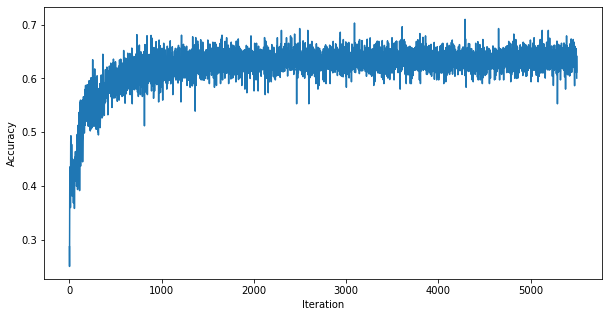

In [16]:
plt.figure(figsize=(10, 5))
plt.ylabel("Accuracy")
plt.xlabel('Iteration')
plt.plot(accs, label='Accuracy vs iteration')
plt.show()

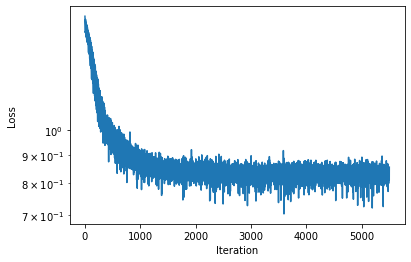

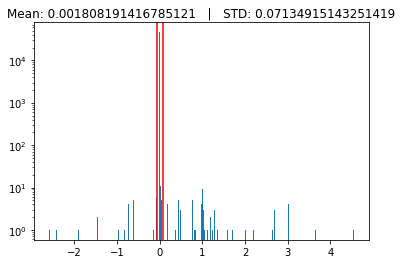

In [17]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel('Iteration')
plt.plot(losses, label='Loss vs iteration')
plt.yscale("log")
plt.show()

plt.figure()
weights = tree.inner_nodes.weight.cpu().detach().numpy().flatten()
plt.hist(weights, bins=500)
weights_std = np.std(weights)
weights_mean = np.mean(weights)
plt.axvline(weights_mean + weights_std, color='r')
plt.axvline(weights_mean - weights_std, color='r')
plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}")
plt.yscale("log")
plt.show()

# Tree Visualization

Average height: 6.754098360655738


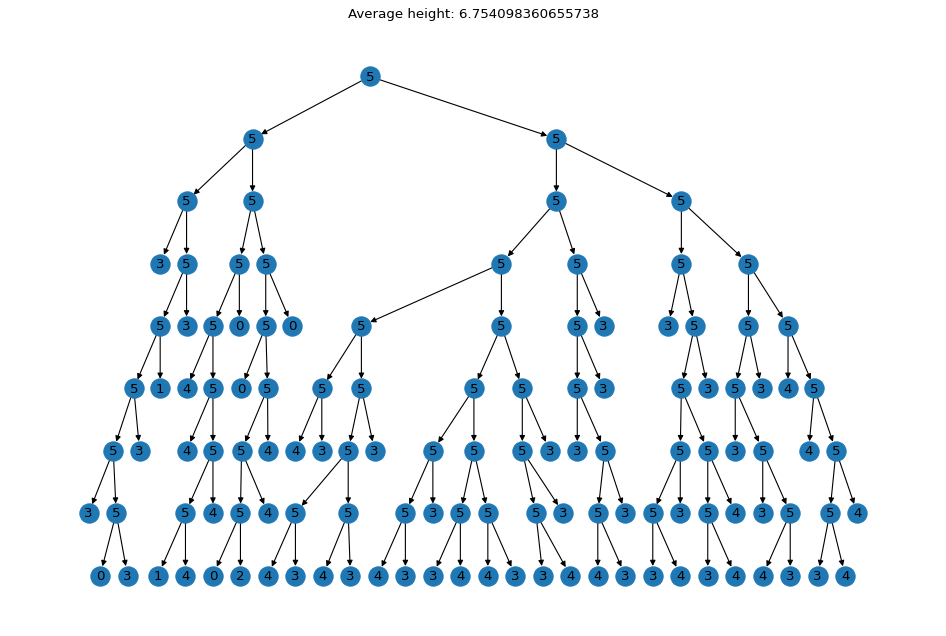

In [18]:
plt.figure(figsize=(15, 10), dpi=80)
avg_height, root = tree.visualize()

# Extract Rules

# Accumulate samples in the leaves

In [19]:
print(f"Number of patterns: {len(root.get_leaves())}")

Number of patterns: 61


In [20]:
method = 'MLE'

In [21]:
root.clear_leaves_samples()

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
        root.accumulate_samples(data, method)

/home/eitan.k/.local/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


# Tighten boundaries

In [22]:
signal_names = dataset.dataset.all_signals
normalizers = torch.tensor([])
attr_names = []
for signal_name in signal_names:
    attr_names += [f"T{i}.{signal_name}" for i in range(sampled.shape[-1])]
    sensor_norm = torch.tensor([torch.tensor(dataset.dataset.sensor_maxs[signal_name]) for _ in range(sampled.shape[-1])])
    normalizers = torch.cat([normalizers, sensor_norm])
    

# print(attr_names)
leaves = root.get_leaves()
sum_comprehensibility = 0
comprehensibilities = []
for pattern_counter, leaf in enumerate(leaves):
    leaf.reset_path()
    leaf.tighten_with_accumulated_samples()
    conds = leaf.get_path_conditions(attr_names)
    for cond in conds:
        cond.weights = cond.weights / normalizers
    print(f"============== Pattern {pattern_counter + 1} ==============")
    comprehensibilities.append(sum([cond.comprehensibility for cond in conds]))
    
print(f"Average comprehensibility: {np.mean(comprehensibilities)}")
print(f"std comprehensibility: {np.std(comprehensibilities)}")
print(f"var comprehensibility: {np.var(comprehensibilities)}")
print(f"minimum comprehensibility: {np.min(comprehensibilities)}")
print(f"maximum comprehensibility: {np.max(comprehensibilities)}")

/home/eitan.k/EntangledExplainableClustering/soft_decision_tree/sdt_model.py:14: RuntimeWarning: divide by zero encountered in log
  return np.log(1 / (1 - x))


============== Pattern 1 ==============
============== Pattern 2 ==============
============== Pattern 3 ==============
============== Pattern 4 ==============
============== Pattern 5 ==============
20293
============== Pattern 6 ==============
============== Pattern 7 ==============
============== Pattern 8 ==============
============== Pattern 9 ==============
============== Pattern 10 ==============
============== Pattern 11 ==============
============== Pattern 12 ==============
============== Pattern 13 ==============
============== Pattern 14 ==============
============== Pattern 15 ==============
============== Pattern 16 ==============
============== Pattern 17 ==============
============== Pattern 18 ==============
============== Pattern 19 ==============
============== Pattern 20 ==============
============== Pattern 21 ==============
============== Pattern 22 ==============
============== Pattern 23 ==============
============== Pattern 24 ==============
============== Patt